In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
structure_path = '/home/ec2-user/SageMaker/data_cache/structure/'
#Get all structured files with the correct prefix
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "FastCharge" in n]
#exclude stitched files
excuded_cells = [str(_) for _ in list(range(292,295)) + list(range(297,307))]
# names = [n for n in names if (not "p2_structure" in n and ".gz" in n and not any(x in n for x in excuded_cells))]
N = len(names)

In [4]:
import pickle
structured_columns = ['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']
summary_columns = ['cycle_index', 'discharge_capacity', 'charge_capacity', 'discharge_energy',
                   'charge_energy', 'charge_throughput', 'energy_throughput']
exclude_count = 0
for i,n in enumerate(names):
    structured_data = []
    summary_data = []
    notes = []
    # check to see if the cell was aleady excluded
    exclude_checker = False
    with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r') as f:
        if n[46:-5] in f.read():
            exclude_checker = True
            print(f'Cell {n[46:-5]} is already excluded. Please check notes.txt for more details.')
#     print(n[46:-5])
#     print(n)
#     break   
    if not exclude_checker:
        if not os.path.exists(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl'):
            cell = auto_load_processed(n)
            manufacturding_nominal_discharge_capacity = 4.84
            # excluding cells that that have less than 50 cycles
            cycle_idx_threshold = 50
            max_cycle_idx = max(cell.structured_data['cycle_index'])
            if not max_cycle_idx < cycle_idx_threshold:
                nominal_discharge_capacity_drop = 1- cell.structured_summary['discharge_capacity'][1]/manufacturding_nominal_discharge_capacity
                # excluding cells that that have more that 80% drop in discharge capacity within 1st cycle
                nominal_discharge_capacity_drop_threshold = 0.8
                if nominal_discharge_capacity_drop < nominal_discharge_capacity_drop_threshold:
                    print(f'Pre-processing data for cell {n[46:-5]}.')
                    for c in tqdm(cell.structured_summary['cycle_index']):
                        clean_cell = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns)
                        structured_data.append(clean_cell)
                    summary_data.append(cell.structured_summary[summary_columns])
        #             features.append(bye_cycle.prep_features_per_cell(cell, n_points,
        #                                                              interpol_kind='quadratic',
        #                                                              columns=['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']))

                    with open(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl','wb') as f: 
                        pickle.dump([structured_data, summary_data], f) 
                else:
                    if nominal_discharge_capacity_drop > nominal_discharge_capacity_drop_threshold:
                        add_txt = f'\n- Cell {n[46:-8]} was skipped as the nominal discharge capacity drop ({nominal_discharge_capacity_drop:.3f}) exceeds {nominal_discharge_capacity_drop_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)
                    if max_cycle_idx < cycle_idx_threshold:
                        add_txt = f'\n- Cell {n[46:-5]} was skipped as the cycle numbers ({max_cycle_idx}) is less than {cycle_idx_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)

In [4]:
def drop_increasing_column(cycle_dataframe, column='discharge_capacity'):
    cycle_data = cycle_dataframe.copy()
#     print(len(cycle_data))
    diff = cycle_data[column] - cycle_data[column].shift(1)
    drop_indices = np.where(diff > 0)[0]
#     print(len(drop_indices))
    drop_cycle_indices = list(cycle_data['cycle_index'].iloc[drop_indices])
    cycle_data.drop(cycle_data.index[drop_indices], axis=0, inplace=True)
    return cycle_data, drop_cycle_indices

# drop_increasing_column(summary_data[0])['discharge_capacity'].is_monotonic_decreasing 
# test = summary_data[0]
def decrease_monotonically(cycle_dataframe, column='discharge_capacity', renumber_cycle_index=True):
    cycle_indices_dropped = []
#     row_wise_difference = (cycle_dataframe[column].shift(1) - cycle_dataframe[column])[1:]
#     print(row_wise_difference)

    while not cycle_dataframe[column].is_monotonic_decreasing:
        cycle_dataframe, _ = drop_increasing_column(cycle_dataframe, column=column)
#         print(len(cycle_dataframe))
        cycle_indices_dropped.append(_)
    cycle_indices_dropped = [x for xs in cycle_indices_dropped for x in xs]
    if renumber_cycle_index:
        cycle_dataframe['cycle_index'] = cycle_dataframe.reset_index(drop=True).index
    return cycle_dataframe, cycle_indices_dropped
# a = decrease_monotonically(summary_data[0])

In [125]:
# read CACHED data 
# excluding all diagnostic cycles and those with increase in discharge cap, renumber based on EFC
cycle_window_size = 50
skip_window_after_diagnostic = 50
structured_data_list = []
summary_data_list = []
nominal_cell_capacity = 1.1
drop_following_diagnostic = False

for i,cell_file in enumerate(tqdm(os.listdir('CACHED_DATA/pre_processed_pandas/LFP/'))):
    print(i, cell_file)
    if cell_file.startswith("Fast"):
        with open(f'CACHED_DATA/pre_processed_pandas/LFP/{cell_file}', 'rb') as f:
            structured_data, summary_data = pickle.load(f)
#         a = find_renumbedred_index(structured_data)
#         print(len(summary_data[0]))
#         break
#         equivalent_cycle_index = summary_data[0]['charge_throughput']/nominal_cell_capacity
#         summary_data[0]['cycle_index'] = equivalent_cycle_index
#         print(summary_data[0]['cycle_index'])
#         print(len(summary_data[0]))
#         break
        if not drop_following_diagnostic:
            cycle_indices_dropped = []
        else:
            summary_data[0], cycle_indices_dropped = decrease_monotonically(summary_data[0])
            print(cycle_indices_dropped)
#         print(len(summary_data[0]))
        # getting equivalent cycle index

#         break
#         print(len(summary_data[0]))
#         skipped_cycles = [list(range(m+1,m+skip_window_after_diagnostic+1)) for m in a]
#         flatten_skipped_cycles = [x for xs in skipped_cycles for x in xs]
        # check if the cell has enough cycles based on the $window_cycles_size
        if len(summary_data[0]) >= cycle_window_size * 2:
            cycle_list = []
            new_cycle_indices = []
            j = 0
            for cycle in structured_data:
                if len(cycle) > 2:
                    cycle_index_value = np.unique(cycle['cycle_index'])[0]
                    if  cycle_index_value not in cycle_indices_dropped:
                        cycle.loc[:,'cycle_index'] = j
                        cycle_list.append(cycle)
                        new_cycle_indices.append(j)
                        j += 1
#                 else:
#                     print(f'TIME-SERIES THRESHOLD ALEERT FOR {i, cell_file}')
            structured_data_list.append(cycle_list)
#             summary_data[0][summary_data[0]['summary_data[0]'] != flatten_skipped_cycles]
#             summary_data[0] = summary_data[0][~summary_data[0]['cycle_index'].isin(flatten_skipped_cycles)]
#             summary_data[0]['cycle_index'] = new_cycle_indices
            summary_data_list.append(summary_data[0])
#             print(len(summary_data_list[i]), len(structured_data_list[i]))
        else:
            print(f'NUMBER OF CYCLES THRESHOLD ALEERT FOR {i, cell_file}')
#         dat.append(cell_data)
#     if i ==2:
#         break
print('CACHED data is loaded.')

  0%|          | 0/141 [00:00<?, ?it/s]

0 FastCharge_000039_CH28_structure.pkl


  1%|          | 1/141 [00:00<00:57,  2.43it/s]

1 FastCharge_000060_CH29_structure.pkl


  1%|▏         | 2/141 [00:00<00:41,  3.33it/s]

2 FastCharge_000017_CH25_structure.pkl


  2%|▏         | 3/141 [00:01<01:05,  2.12it/s]

3 FastCharge_000040_CH32_structure.pkl


  3%|▎         | 4/141 [00:01<00:50,  2.71it/s]

4 FastCharge_000004_CH2_structure.pkl


  4%|▎         | 5/141 [00:01<00:51,  2.64it/s]

5 FastCharge_000008_CH47_structure.pkl


  4%|▍         | 6/141 [00:02<00:45,  2.94it/s]

6 FastCharge_000029_CH10_structure.pkl


  6%|▌         | 8/141 [00:02<00:37,  3.58it/s]

7 FastCharge_000022_CH24_structure.pkl
8 FastCharge_000013_CH13_structure.pkl


  6%|▋         | 9/141 [00:03<00:40,  3.27it/s]

9 FastCharge_000017_CH9_structure.pkl


  7%|▋         | 10/141 [00:03<00:57,  2.28it/s]

10 FastCharge_000036_CH48_structure.pkl


  8%|▊         | 11/141 [00:04<00:51,  2.51it/s]

11 FastCharge_000037_CH22_structure.pkl


  9%|▊         | 12/141 [00:04<00:50,  2.55it/s]

12 FastCharge_000028_CH19_structure.pkl


  9%|▉         | 13/141 [00:04<00:49,  2.60it/s]

13 FastCharge_000012_CH23_structure.pkl


 11%|█         | 15/141 [00:06<01:00,  2.09it/s]

14 FastCharge_000062_CH47_structure.pkl
15 FastCharge_000007_CH24_structure.pkl


 11%|█▏        | 16/141 [00:06<00:55,  2.25it/s]

16 FastCharge_000006_CH8_structure.pkl


 12%|█▏        | 17/141 [00:06<00:53,  2.33it/s]

17 FastCharge_000047_CH21_structure.pkl


 13%|█▎        | 18/141 [00:07<00:44,  2.73it/s]

18 .ipynb_checkpoints
19 FastCharge_000037_CH21_structure.pkl


 14%|█▍        | 20/141 [00:07<00:34,  3.51it/s]

20 FastCharge_000015_CH28_structure.pkl


 15%|█▍        | 21/141 [00:07<00:39,  3.00it/s]

21 FastCharge_000019_CH30_structure.pkl


 16%|█▌        | 22/141 [00:08<00:39,  3.03it/s]

22 FastCharge_000052_CH41_structure.pkl


 16%|█▋        | 23/141 [00:08<00:35,  3.34it/s]

23 FastCharge_000058_CH46_structure.pkl


 17%|█▋        | 24/141 [00:08<00:34,  3.43it/s]

24 FastCharge_000014_CH24_structure.pkl


 18%|█▊        | 26/141 [00:09<00:41,  2.77it/s]

25 FastCharge_000053_CH42_structure.pkl
26 FastCharge_000024_CH45_structure.pkl


 19%|█▉        | 27/141 [00:09<00:35,  3.20it/s]

27 FastCharge_000015_CH44_structure.pkl


 20%|█▉        | 28/141 [00:10<00:39,  2.83it/s]

28 FastCharge_000063_CH6_structure.pkl


 21%|██        | 29/141 [00:10<00:44,  2.51it/s]

29 FastCharge_000002_CH7_structure.pkl


 22%|██▏       | 31/141 [00:11<00:38,  2.89it/s]

30 FastCharge_000009_CH7_structure.pkl
31 FastCharge_000015_CH14_structure.pkl


 23%|██▎       | 32/141 [00:11<00:40,  2.69it/s]

32 FastCharge_000006_CH3_structure.pkl


 23%|██▎       | 33/141 [00:12<00:40,  2.66it/s]

33 FastCharge_000039_CH27_structure.pkl


 24%|██▍       | 34/141 [00:12<00:39,  2.71it/s]

34 FastCharge_000001_CH38_structure.pkl


 25%|██▍       | 35/141 [00:12<00:34,  3.08it/s]

35 FastCharge_000004_CH1_structure.pkl


 26%|██▌       | 36/141 [00:13<00:48,  2.18it/s]

36 FastCharge_000015_CH36_structure.pkl


 26%|██▌       | 37/141 [00:14<00:46,  2.23it/s]

37 FastCharge_000029_CH9_structure.pkl


 27%|██▋       | 38/141 [00:14<00:43,  2.38it/s]

38 FastCharge_000016_CH17_structure.pkl


 28%|██▊       | 39/141 [00:14<00:36,  2.79it/s]

39 FastCharge_000006_CH27_structure.pkl


 28%|██▊       | 40/141 [00:15<00:41,  2.42it/s]

40 FastCharge_000002_CH2_structure.pkl


 29%|██▉       | 41/141 [00:15<00:38,  2.56it/s]

41 FastCharge_000021_CH28_structure.pkl


 30%|██▉       | 42/141 [00:15<00:33,  3.00it/s]

42 FastCharge_000012_CH29_structure.pkl


 30%|███       | 43/141 [00:16<00:36,  2.66it/s]

43 FastCharge_000058_CH45_structure.pkl


 31%|███       | 44/141 [00:16<00:34,  2.85it/s]

44 FastCharge_000001_CH30_structure.pkl


 32%|███▏      | 45/141 [00:16<00:32,  2.92it/s]

45 FastCharge_000017_CH17_structure.pkl


 33%|███▎      | 46/141 [00:17<00:44,  2.15it/s]

46 FastCharge_000032_CH22_structure.pkl


 34%|███▍      | 48/141 [00:18<00:41,  2.25it/s]

47 FastCharge_000035_CH12_structure.pkl
48 FastCharge_000012_CH15_structure.pkl


 35%|███▍      | 49/141 [00:18<00:38,  2.41it/s]

49 FastCharge_000012_CH21_structure.pkl


 35%|███▌      | 50/141 [00:19<00:37,  2.45it/s]

50 FastCharge_000017_CH46_structure.pkl


 36%|███▌      | 51/141 [00:19<00:41,  2.18it/s]

51 FastCharge_000034_CH27_structure.pkl


 37%|███▋      | 52/141 [00:20<00:34,  2.59it/s]

52 FastCharge_000063_CH5_structure.pkl


 38%|███▊      | 53/141 [00:20<00:37,  2.38it/s]

53 FastCharge_000017_CH33_structure.pkl


 38%|███▊      | 54/141 [00:21<00:49,  1.76it/s]

54 FastCharge_000006_CH19_structure.pkl


 39%|███▉      | 55/141 [00:21<00:45,  1.89it/s]

55 FastCharge_000051_CH16_structure.pkl


 40%|███▉      | 56/141 [00:22<00:39,  2.17it/s]

56 FastCharge_000012_CH37_structure.pkl


 40%|████      | 57/141 [00:22<00:36,  2.33it/s]

57 FastCharge_000057_CH35_structure.pkl


 41%|████      | 58/141 [00:22<00:32,  2.56it/s]

58 FastCharge_000070_CH46_structure.pkl


 42%|████▏     | 59/141 [00:23<00:27,  2.96it/s]

59 FastCharge_000056_CH11_structure.pkl


 43%|████▎     | 60/141 [00:23<00:40,  2.00it/s]

60 FastCharge_000066_CH25_structure.pkl


 43%|████▎     | 61/141 [00:24<00:38,  2.10it/s]

61 FastCharge_000002_CH42_structure.pkl


 44%|████▍     | 62/141 [00:24<00:38,  2.03it/s]

62 FastCharge_000005_CH18_structure.pkl


 45%|████▍     | 63/141 [00:25<00:31,  2.44it/s]

63 FastCharge_000002_CH47_structure.pkl


 45%|████▌     | 64/141 [00:25<00:40,  1.89it/s]

64 FastCharge_000008_CH48_structure.pkl


 46%|████▌     | 65/141 [00:26<00:33,  2.24it/s]

65 FastCharge_000066_CH26_structure.pkl


 47%|████▋     | 66/141 [00:26<00:31,  2.37it/s]

66 FastCharge_000015_CH4_structure.pkl


 48%|████▊     | 67/141 [00:26<00:29,  2.53it/s]

67 FastCharge_000026_CH5_structure.pkl
68 FastCharge_000009_CH8_structure.pkl


 49%|████▉     | 69/141 [00:27<00:20,  3.58it/s]

69 FastCharge_000012_CH13_structure.pkl


 50%|████▉     | 70/141 [00:27<00:23,  3.08it/s]

70 FastCharge_000015_CH20_structure.pkl


 50%|█████     | 71/141 [00:27<00:23,  3.03it/s]

71 FastCharge_000006_CH35_structure.pkl


 51%|█████     | 72/141 [00:28<00:24,  2.84it/s]

72 FastCharge_000045_CH3_structure.pkl


 52%|█████▏    | 73/141 [00:28<00:26,  2.59it/s]

73 FastCharge_000041_CH10_structure.pkl
74 FastCharge_000061_CH43_structure.pkl


 53%|█████▎    | 75/141 [00:29<00:18,  3.62it/s]

75 FastCharge_000054_CH15_structure.pkl


 54%|█████▍    | 76/141 [00:29<00:17,  3.80it/s]

76 FastCharge_000073_CH35_structure.pkl


 55%|█████▍    | 77/141 [00:29<00:16,  3.97it/s]

77 FastCharge_000044_CH12_structure.pkl


 55%|█████▌    | 78/141 [00:30<00:28,  2.17it/s]

78 FastCharge_000001_CH16_structure.pkl


 57%|█████▋    | 80/141 [00:31<00:21,  2.89it/s]

79 FastCharge_000038_CH13_structure.pkl
80 FastCharge_000055_CH20_structure.pkl


 57%|█████▋    | 81/141 [00:31<00:18,  3.22it/s]

81 FastCharge_000002_CH34_structure.pkl


 58%|█████▊    | 82/141 [00:31<00:18,  3.13it/s]

82 FastCharge_000017_CH41_structure.pkl


 59%|█████▉    | 83/141 [00:32<00:28,  2.02it/s]

83 FastCharge_000065_CH33_structure.pkl


 60%|█████▉    | 84/141 [00:32<00:25,  2.20it/s]

84 FastCharge_000023_CH38_structure.pkl


 60%|██████    | 85/141 [00:33<00:22,  2.50it/s]

85 FastCharge_000068_CH38_structure.pkl


 61%|██████    | 86/141 [00:33<00:18,  2.92it/s]

86 FastCharge_000069_CH25_structure.pkl


 62%|██████▏   | 87/141 [00:33<00:16,  3.26it/s]

87 FastCharge_000006_CH11_structure.pkl


 63%|██████▎   | 89/141 [00:34<00:15,  3.30it/s]

88 FastCharge_000042_CH36_structure.pkl
89 FastCharge_000002_CH18_structure.pkl


 64%|██████▍   | 90/141 [00:34<00:16,  3.17it/s]

90 FastCharge_000067_CH42_structure.pkl


 65%|██████▍   | 91/141 [00:34<00:14,  3.35it/s]

91 FastCharge_000025_CH7_structure.pkl


 65%|██████▌   | 92/141 [00:35<00:16,  2.94it/s]

92 FastCharge_000019_CH29_structure.pkl


 66%|██████▌   | 93/141 [00:35<00:15,  3.03it/s]

93 FastCharge_000015_CH12_structure.pkl


 67%|██████▋   | 94/141 [00:36<00:18,  2.58it/s]

94 FastCharge_000045_CH1_structure.pkl


 67%|██████▋   | 95/141 [00:36<00:19,  2.41it/s]

95 FastCharge_000046_CH32_structure.pkl


 68%|██████▊   | 96/141 [00:37<00:18,  2.39it/s]

96 FastCharge_000023_CH37_structure.pkl


 69%|██████▉   | 97/141 [00:38<00:29,  1.51it/s]

97 FastCharge_000012_CH45_structure.pkl


 70%|██████▉   | 98/141 [00:38<00:24,  1.73it/s]

98 FastCharge_000045_CH2_structure.pkl


 70%|███████   | 99/141 [00:39<00:22,  1.83it/s]

99 FastCharge_000027_CH31_structure.pkl


 71%|███████   | 100/141 [00:39<00:18,  2.24it/s]

100 FastCharge_000050_CH40_structure.pkl


 72%|███████▏  | 101/141 [00:39<00:16,  2.48it/s]

101 FastCharge_000017_CH6_structure.pkl


 72%|███████▏  | 102/141 [00:40<00:18,  2.06it/s]

102 FastCharge_000048_CH43_structure.pkl


 73%|███████▎  | 103/141 [00:40<00:17,  2.16it/s]

103 FastCharge_000057_CH36_structure.pkl


 74%|███████▍  | 104/141 [00:41<00:16,  2.31it/s]

104 FastCharge_000018_CH18_structure.pkl


 74%|███████▍  | 105/141 [00:41<00:14,  2.47it/s]

105 FastCharge_000059_CH33_structure.pkl


 75%|███████▌  | 106/141 [00:41<00:12,  2.87it/s]

106 FastCharge_000051_CH15_structure.pkl


 76%|███████▌  | 107/141 [00:42<00:11,  2.86it/s]

107 FastCharge_000048_CH44_structure.pkl


 77%|███████▋  | 108/141 [00:42<00:12,  2.66it/s]

108 FastCharge_000007_CH39_structure.pkl


 77%|███████▋  | 109/141 [00:42<00:11,  2.71it/s]

109 FastCharge_000046_CH31_structure.pkl


 79%|███████▊  | 111/141 [00:43<00:09,  3.14it/s]

110 FastCharge_000000_CH19_structure.pkl
111 FastCharge_000071_CH40_structure.pkl


 79%|███████▉  | 112/141 [00:43<00:08,  3.52it/s]

112 FastCharge_000002_CH10_structure.pkl


 81%|████████  | 114/141 [00:44<00:07,  3.49it/s]

113 FastCharge_000026_CH6_structure.pkl
114 FastCharge_000020_CH23_structure.pkl


 82%|████████▏ | 115/141 [00:44<00:06,  3.73it/s]

115 FastCharge_000014_CH23_structure.pkl


 82%|████████▏ | 116/141 [00:44<00:07,  3.44it/s]

116 FastCharge_000065_CH34_structure.pkl


 83%|████████▎ | 117/141 [00:45<00:07,  3.23it/s]

117 FastCharge_000013_CH14_structure.pkl


 84%|████████▎ | 118/141 [00:45<00:07,  3.16it/s]

118 FastCharge_000028_CH20_structure.pkl


 85%|████████▌ | 120/141 [00:47<00:11,  1.89it/s]

119 FastCharge_000064_CH39_structure.pkl
120 FastCharge_000017_CH1_structure.pkl


 86%|████████▌ | 121/141 [00:47<00:10,  2.00it/s]

121 FastCharge_000050_CH32_structure.pkl


 87%|████████▋ | 122/141 [00:47<00:09,  2.11it/s]

122 FastCharge_000030_CH30_structure.pkl


 87%|████████▋ | 123/141 [00:48<00:07,  2.53it/s]

123 FastCharge_000003_CH39_structure.pkl


 88%|████████▊ | 124/141 [00:48<00:06,  2.70it/s]

124 FastCharge_000044_CH11_structure.pkl


 89%|████████▊ | 125/141 [00:48<00:05,  3.07it/s]

125 FastCharge_000033_CH14_structure.pkl


 89%|████████▉ | 126/141 [00:48<00:04,  3.45it/s]

126 FastCharge_000004_CH3_structure.pkl


 90%|█████████ | 127/141 [00:49<00:04,  3.02it/s]

127 FastCharge_000049_CH37_structure.pkl


 91%|█████████ | 128/141 [00:49<00:03,  3.31it/s]

128 notes.txt
129 FastCharge_000012_CH5_structure.pkl


 92%|█████████▏| 130/141 [00:49<00:02,  4.20it/s]

130 FastCharge_000067_CH41_structure.pkl


 93%|█████████▎| 131/141 [00:50<00:02,  4.15it/s]

131 FastCharge_000072_CH34_structure.pkl


 94%|█████████▍| 133/141 [00:50<00:01,  4.79it/s]

132 FastCharge_000031_CH9_structure.pkl
133 FastCharge_000010_CH44_structure.pkl


 95%|█████████▌| 134/141 [00:50<00:01,  4.83it/s]

134 FastCharge_000006_CH43_structure.pkl


 96%|█████████▌| 135/141 [00:51<00:01,  3.51it/s]

135 FastCharge_000011_CH26_structure.pkl


 96%|█████████▋| 136/141 [00:51<00:01,  3.75it/s]

136 FastCharge_000009_CH4_structure.pkl


 97%|█████████▋| 137/141 [00:51<00:01,  3.98it/s]

137 FastCharge_000015_CH22_structure.pkl


 98%|█████████▊| 138/141 [00:51<00:00,  3.60it/s]

138 FastCharge_000006_CH48_structure.pkl


 99%|█████████▊| 139/141 [00:52<00:00,  2.96it/s]

139 FastCharge_000043_CH16_structure.pkl


 99%|█████████▉| 140/141 [00:52<00:00,  3.21it/s]

140 FastCharge_000003_CH40_structure.pkl


100%|██████████| 141/141 [00:53<00:00,  2.66it/s]

CACHED data is loaded.


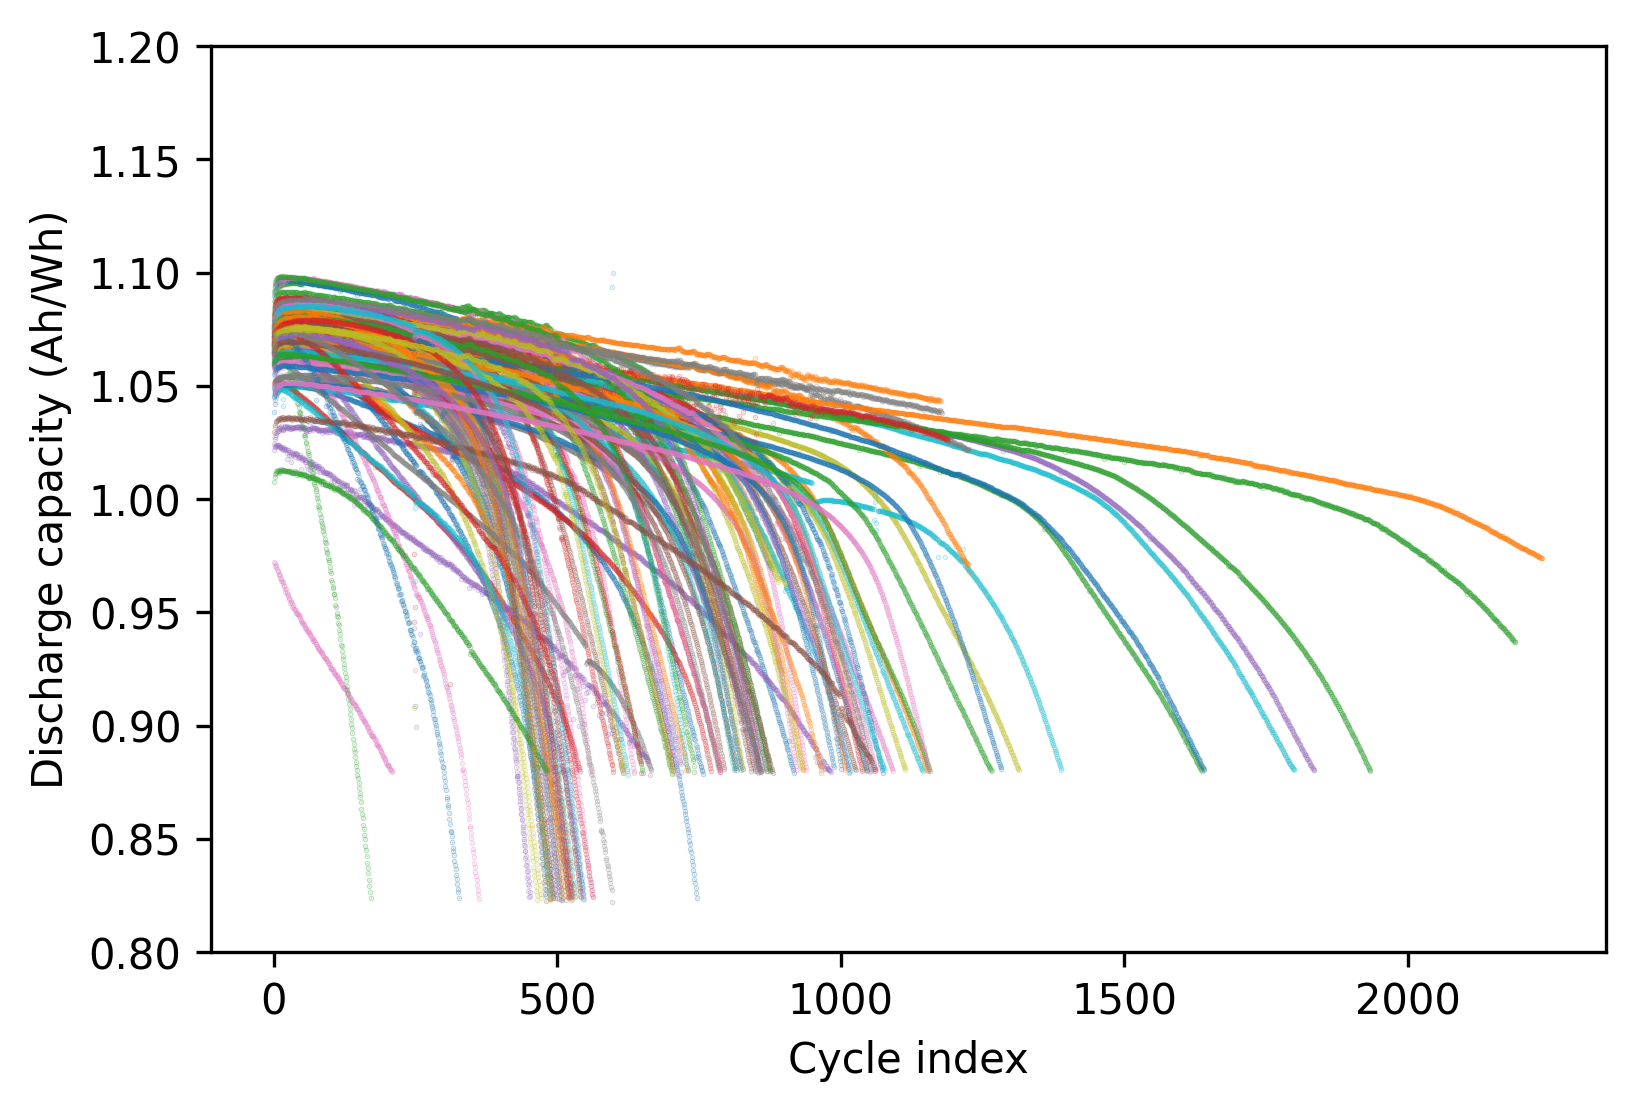

In [129]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycle index')
plt.ylabel('Discharge capacity (Ah/Wh)')
plt.ylim([0.8, 1.2])
plt.savefig(f'LFP_dataset.png', dpi=400, transparent=False)

In [42]:
def find_slope(cycle_window_label):
    mid_window_index = len(cycle_window_label)//2
    low = np.array(cycle_window_label)[0]
    mid = np.array(cycle_window_label)[mid_window_index]
    high = np.array(cycle_window_label)[-1]
    slope_1 = (mid[1] - low[1]) / (mid[0] - low[0]) # mid_window_index #
    slope_2 = (high[1] - mid[1]) / (mid[0] - low[0]) # mid_window_index
    return slope_1, slope_2

import pickle as pkl
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP/fearures_labels_inputs_window_{cycle_window_size}_outputs_window_{cycle_window_size}.pkl'

if not os.path.exists(pkl_f_l_filename):

    skip_diagnostic_in_window = False

    features_columns = ['cycle_index','voltage', 'current']
    label_columns = ['cycle_index', 'discharge_capacity']
    # features = np.empty([0, None,100, 3])
    monitored_cycles_discharge_capacity = []
    labels = np.empty([0, 2])
    cell_features = []
    cell_labels = []
    cell_discharge_caps = []
    initial_discharge_cap_windows = []
    for i, cell in enumerate(tqdm(structured_data_list)):
    #     print(i)
    #     n = len(cell)//cycle_numbers
        cycle_window_features = []
        cycle_window_labels = []
        initial_discharge_cap = []
        cell_cycle_indices = summary_data_list[i]['cycle_index'].values
        index_convolution = bye_cycle.index_convoluter(cell, overlap_cycle_window=False, 
                                             overlap_size=10, cycle_window_size=cycle_window_size,
                                                       skip_diagnostic_in_window=skip_diagnostic_in_window)
    #     print(len(index_convolution))
        for j, index_list in enumerate(index_convolution):
    #         if (j < len(index_convolution)-1):
                cycle_window_features.append(list(zip(*[(bye_cycle.interpol_cycle(cell[cycle_index], columns=features_columns, n_points=100)
                                                         , len(cell[cycle_index]))
                                     for cycle_index in index_list])))
        #         break
        #         print (index_list)
        #         print(summary_data_list[i][label_columns])
        #         discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[index_list]
    #             print(index_convolution[j])
                discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[index_convolution[j]]

                cycle_window_labels.append(list([find_slope(discharge_cap_cycle_window),discharge_cap_cycle_window]))
    #         if j == 0:
    #             initial_discharge_cap.append(np.array(summary_data_list[i][label_columns])[index_convolution[j]])
        #         cycle_window_labels.append(discharge_cap_cycle_window)
        #     break
        cell_features.append(cycle_window_features)
        cell_labels.append(cycle_window_labels)
    #     initial_discharge_cap_windows.append(initial_discharge_cap)
    with open(pkl_f_l_filename, 'wb') as f:
        pkl.dump([cell_features, cell_labels], f)
else:
    print('Loaded CACHED pickled files for features and labels.')
    with open(pkl_f_l_filename, 'rb') as f:
        [cell_features, cell_labels] = pkl.load(f)  

Loaded CACHED pickled files for features and labels.


In [124]:
cell = structured_data_list[0]

def index_convoluter(cell, cycle_window_size=20, overlap_cycle_window=False,
                     overlap_size=5, skip_diagnostic_in_window=False):
    '''This function generates a nested list of indices by convolting the cycles based on cycle_window_size. 
        You can choose to have your window of cycles overlap, or skipp the windows that involve diagnostic cycles in between.
    '''
    max_cycle_index = len(cell) #30 #
    if cycle_window_size < overlap_size:
        raise ValueError(f'If overlapping, overlap_size ({overlap_size}) should be samller than cycle_window_size ({cycle_window_size}). Please check inputs.')
    if not cycle_window_size < max_cycle_index:
        raise ValueError(f'cycle_window_size ({cycle_window_size}) should be samller than maximum number of cycles in cell ({max_cycle_index}). Please check inputs.')
    if overlap_cycle_window:
        non_overlap =  cycle_window_size - overlap_size
    else:
        non_overlap = cycle_window_size
    intervals = range(0, max_cycle_index, non_overlap)
    if not skip_diagnostic_in_window:
        index_covolutions = [list(range(x, x + cycle_window_size)) for x in intervals if x <= max_cycle_index-cycle_window_size]
    else:
#         skipped_indices = [5, 6, 7, 20]
        skipped_indices = find_renumbedred_index(cell)
        index_covolutions = [list(range(x, x + cycle_window_size)) for x in intervals if x <= max_cycle_index-cycle_window_size
                             and not (set(list(range(x, x + cycle_window_size))[:-1]) & set(skipped_indices))]
    return index_covolutions

index_convolution = index_convoluter(cell, overlap_cycle_window=False, 
                                     overlap_size=10, cycle_window_size=cycle_window_size,
                                               skip_diagnostic_in_window=False)
print(index_convolution)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [130]:
import random
prepared_data = list(zip(cell_features, cell_labels))

random.seed(0)
shuffled_indices = list(range(len(prepared_data)))
random.shuffle(prepared_data)
# prepared_data = prepared_data[shuffled_indices]

train_size = 0.9
val_size = 0.2
N_train = int(train_size *len(prepared_data))
N_val = int(val_size * N_train)
train_cells = prepared_data[:N_train]
test_cells = prepared_data[N_train:]

val_cells = train_cells[:N_val]
train_cells = train_cells[N_val:]
print(len(train_cells), len(val_cells), len(test_cells), len(train_cells)+len(test_cells)+len(val_cells))

100 25 14 139


In [131]:
def scale(inputs, scaler=None):
    from sklearn import preprocessing
    inputs_shape = inputs.shape
    if scaler is None:
        scaler = preprocessing.StandardScaler().fit(inputs.reshape(-1, inputs_shape[-1]))
    scaled_input = scaler.transform(inputs.reshape(-1, inputs_shape[-1])).reshape(inputs_shape)
    return scaler, scaled_input

def rev_scale(scaled_inputs, scaler):
    scaled_inputs_shape = scaled_inputs.shape
    origin_inputs = scaler.inverse_transform(scaled_X_train_time_series.reshape(-1, scaled_inputs_shape[-1]))
    return origin_inputs.reshape(scaled_inputs_shape)



def standardize_train(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features, fmean, fstd

def standardize_non_train(inputs, fmean_train, fstd_train):
    std_features = (inputs - fmean_train) / fstd_train
    return std_features

def de_standardize_non_train(inputs, fmean_train, fstd_train):
    return inputs*fstd_train + fmean_train

def make_feature_arrays(data):
    X_dt_values = []
    X_time_series = []
    for X in data[:-1]:
        X_dt_values.append(X[1])
        X_time_series.append(X[0])
#         break
    return np.array(X_time_series), np.array(X_dt_values)

def make_label_arrays(data):
    slopes = []
    discharge_cap = []
    for Y in data[1:]:
        discharge_cap.append(Y[1])
        slopes.append(Y[0])
    return np.array(discharge_cap), np.array(slopes)

X_train = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
Y_train = [x for xs in train_cells for x in xs[1]]
dc_train, slopes_train = make_label_arrays(Y_train)
X_train_time_series, X_train_dt = make_feature_arrays(X_train)
print(X_train_time_series[0,0,0,0])
print(dc_train[0][0])
# print(X_train_time_series[0])
import random
random.seed(0)
indices = list(range(len(X_train_time_series)))
random.shuffle(indices)
print(f'len features {len(X_train_time_series)}')
X_train_time_series = X_train_time_series[indices]
X_train_dt = X_train_dt[indices]


slopes_train = slopes_train[indices]
# standardized_train_slopes, mean_train_slopes, std_train_slopes= standardize_train(slopes_train)
dc_train = dc_train[indices]
print(X_train_time_series[0,0,0,0])
print(dc_train[0][0])

X_val = [x for xs in val_cells for x in xs[0]]
# Y_val= np.array([x for xs in val_cells for x in xs[1]])
Y_val = [x for xs in val_cells for x in xs[1]]
dc_val, slopes_val = make_label_arrays(Y_val)
# standardized_val_slopes= standardize_non_train(slopes_val, mean_train_slopes, std_train_slopes)
X_val_time_series, X_val_dt = make_feature_arrays(X_val)

X_test = [x for xs in test_cells for x in xs[0]]
# Y_test= np.array([x for xs in test_cells for x in xs[1]])
Y_test = [x for xs in test_cells for x in xs[1]]
dc_test, slopes_test = make_label_arrays(Y_test)
# standardized_test_slopes= standardize_non_train(slopes_test, mean_train_slopes, std_train_slopes)
X_test_time_series, X_test_dt = make_feature_arrays(X_test)

f_scaler, scaled_X_train_time_series = scale(X_train_time_series[...,1:])
_ , scaled_X_val_time_series = scale(X_val_time_series[...,1:], f_scaler)
_ , scaled_X_test_time_series = scale(X_test_time_series[...,1:], f_scaler)
# scaled_X_val_time_series = scaler.transform(X_val_time_series[...,1:])

l_scaler, scaled_slopes_train = scale(slopes_train)
_ , scaled_slopes_val = scale(slopes_val, l_scaler)
_ , scaled_slopes_test = scale(slopes_test, l_scaler)

0.0
[50.     1.091]
len features 1613
950.0
[0.    1.954]


Text(0.5, 1.0, 'slope 1')

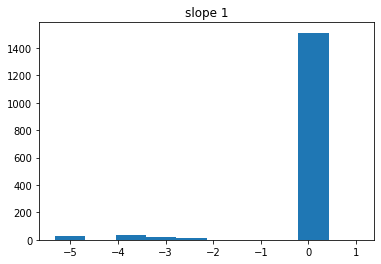

In [132]:
plt.hist(scaled_slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

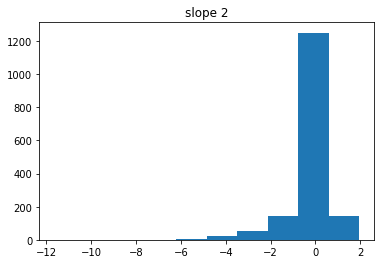

In [133]:
plt.hist(scaled_slopes_train[:,1])
plt.title('slope 2')

In [47]:
# def oversample(f_time_series, f_dt, labels, oversample_label_index=1):
#     counts, bins, patches = plt.hist(labels[:,oversample_label_index])
#     plt.close()
#     import numpy_indexed as npi
#     import random
#     max_samples = max(counts)
#     ind = np.digitize(labels[:,oversample_label_index], bins)
#     label_groups = npi.group_by(ind).split(labels[:,oversample_label_index])

#     balanced_f_time_series = f_time_series
#     balanced_labels = labels
#     balanced_f_dt = f_dt
#     for sg in tqdm(label_groups[:-2]):
#         n_samples = int(max_samples - len(sg))
#         # Find indices for samples
#         sample_indices = npi.indices(labels[:, oversample_label_index], np.random.choice(sg, n_samples))
#         balanced_f_time_series = np.append(balanced_f_time_series,
#                                                      f_time_series[sample_indices], axis=0)
#         balanced_labels = np.append(balanced_labels,
#                                                      labels[sample_indices], axis=0)
#         balanced_f_dt = np.append(balanced_f_dt,
#                                                 f_dt[sample_indices], axis=0)
    
# #     random.seed(0)
#     shuffled_indices = list(range(len(balanced_f_time_series)))
#     random.shuffle(indices)
#     return balanced_f_time_series[shuffled_indices], balanced_f_dt[shuffled_indices], balanced_labels[shuffled_indices]

# balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(scaled_X_train_time_series,
#                                                                                                X_train_dt,
#                                                                                                scaled_slopes_train, oversample_label_index=0)
# # balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(balanced_X_train_time_series,
# #                                                                                                balanced_X_train_dt,
# #                                                                                                balanced_slopes_train, oversample_label_index=0)

Text(0.5, 1.0, 'slope 1')

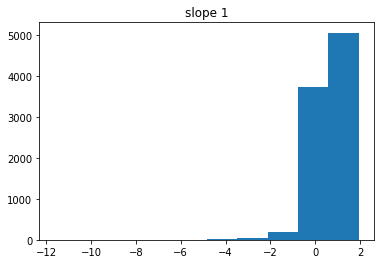

In [767]:
# plt.hist(balanced_slopes_train[:,1])
# plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

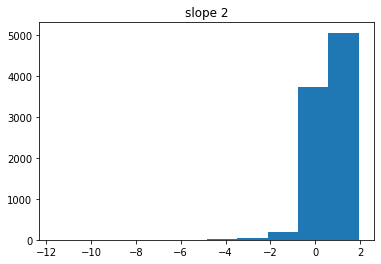

In [768]:
# plt.hist(balanced_slopes_train[:,1])
# plt.title('slope 2')

In [769]:
# scaled_X_train_dt, mean_X_train_dt, std_X_train_dt  = standardize_train(X_train_dt)
# scaled_X_val_dt = standardize_non_train(X_val_dt, mean_X_train_dt, std_X_train_dt)

# scaled_X_train_time_series, mean_X_train_time_series, std_X_train_time_series = standardize_train(X_train_time_series)
# scaled_X_val_time_series = standardize_non_train(X_val_time_series, mean_X_train_time_series, std_X_train_time_series)
# X_train_time_series = X_train_time_series
# print
# scaled_X_train_time_series = scaled_X_train_time_series[...,1:]
# scaled_X_val_time_series = scaled_X_val_time_series[...,1:]


# test_X_train_time_series = rev_scale(scaled_X_train_time_series[...,1:], scaler)


In [134]:
from dataclasses import dataclass
@dataclass
class Config:
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def build_model(L, T, cycle_window_size=10, reg_strength=0):
    inputs = tf.keras.Input(shape=(cycle_window_size,T,2))
    input_dt = tf.keras.Input(shape=(cycle_window_size))
    print(f'input: {inputs.shape}')
    print(f'input_dt: {input_dt.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(32, 50, activation='relu')
#     max_pooling = 
#     blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
#     x = tf.keras.layers.Embedding(100,16)(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 100), input_shape=(cycle_window_size, 100, 2))(inputs)
    print(f'output 1 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 1: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 10 ,2))(x)
#     print(f'output 2 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 3: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 10), input_shape=(cycle_window_size, 2))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(100, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(max_pooling)(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(config.drop_rate))(x)
    print(f'output dropout: {x.shape}')
#     x = tf.keras.layers.Reshape((cycle_window_size, 32))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     
    print(f'output GlobalAveragePooling1D: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    print(x.shape)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    print(f'output bilstm dist: {x.shape}')
#     x = tf.keras.layers.Concatenate()([x, input_dt])
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    yhat = tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.L2(l2=reg_strength)
                                 )(x) # activation=tf.keras.layers.LeakyReLU(alpha=0.01)
#     model = tf.keras.Model(inputs=[inputs, input_dt], outputs=yhat)
    model = tf.keras.Model(inputs=inputs, outputs=yhat)
    return model
tf.keras.backend.clear_session()
L = None
T = 100

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
model = build_model(L, T, cycle_window_size=cycle_window_size, reg_strength=0)
opt = tf.optimizers.Adam(1e-3)
model.compile(opt, loss='mae')  #root_mean_squared_error
#   loss='mean_absolute_error')
  
model.summary()


input: (None, 50, 100, 2)
input_dt: (None, 50)
output 1 conv: (None, 50, 1, 32)
output dropout: (None, 50, 1, 32)
output GlobalAveragePooling1D: (None, 50, 32)
(None, 50, 32)
output bilstm dist: (None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 100, 2)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 1, 32)        6432      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 1, 32)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 32)           0         
 tributed)                                           

In [135]:
# result = model.fit(
#     scaled_X_train_time_series, -np.log(-balanced_slopes_train), # standardize
# #     scaled_X_train_time_series, balanced_slopes_train,
#     validation_data=(scaled_X_val_time_series, -np.log(-slopes_val)), 
# #     validation_data=(scaled_X_val_time_series, slopes_val), 
#     callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
#             monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
#         ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# # #         tf.keras.callbacks.LambdaCallback(
# # #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# # #         ),
# #         ,
#     epochs=150, batch_size=16)

result = model.fit( 
#     balanced_X_train_time_series, balanced_slopes_train, # standardize

    scaled_X_train_time_series, scaled_slopes_train, # standardize
    validation_data=(scaled_X_val_time_series, scaled_slopes_val), 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=30)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=200, batch_size=16)

Epoch 1/200
101/101 [==============================] - 7s 32ms/step - loss: 0.6217 - val_loss: 0.3921 - lr: 0.0010
Epoch 2/200
101/101 [==============================] - 2s 22ms/step - loss: 0.5183 - val_loss: 0.4018 - lr: 0.0010
Epoch 3/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4565 - val_loss: 0.3921 - lr: 0.0010
Epoch 4/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4377 - val_loss: 0.3870 - lr: 0.0010
Epoch 5/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4286 - val_loss: 0.3882 - lr: 0.0010
Epoch 6/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4188 - val_loss: 0.3753 - lr: 0.0010
Epoch 7/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4105 - val_loss: 0.3450 - lr: 0.0010
Epoch 8/200
101/101 [==============================] - 2s 22ms/step - loss: 0.4152 - val_loss: 0.3857 - lr: 0.0010
Epoch 9/200
101/101 [==============================] - 2s 22ms/step - loss: 0.41

Epoch 70/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2518 - val_loss: 0.2697 - lr: 6.5610e-04
Epoch 71/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2483 - val_loss: 0.2770 - lr: 6.5610e-04
Epoch 72/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2404 - val_loss: 0.2859 - lr: 6.5610e-04
Epoch 73/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2381 - val_loss: 0.2757 - lr: 6.5610e-04
Epoch 74/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2533 - val_loss: 0.2577 - lr: 6.5610e-04
Epoch 75/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2295 - val_loss: 0.2638 - lr: 6.5610e-04
Epoch 76/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2225 - val_loss: 0.2501 - lr: 6.5610e-04
Epoch 77/200
101/101 [==============================] - 2s 22ms/step - loss: 0.2079 - val_loss: 0.2652 - lr: 6.5610e-04
Epoch 78/200
101/101 [==================

In [136]:
# model_json = model.to_json()
# with open(f"saved_models/LFP/model_window_size_inputs_window_{cycle_window_size}_outputs_window_{cycle_window_size}.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(f"saved_models/LFP/model_window_size_inputs_window_{cycle_window_size}_outputs_window_{cycle_window_size}.h5")

Text(0.5, 0, 'Epochs')

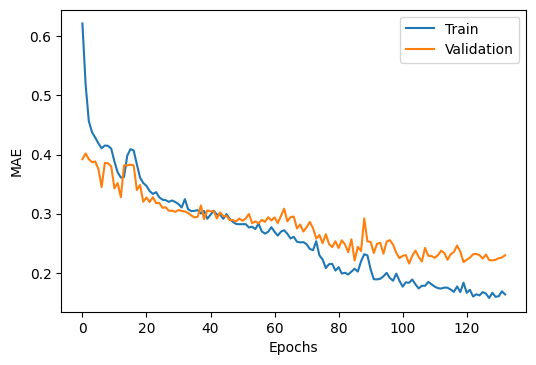

In [137]:
plt.figure(dpi=100)
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')
# plt.xlim([100, 150])

In [138]:
test_result = model.evaluate(scaled_X_test_time_series, scaled_slopes_test)
# test_result = model.evaluate(scaled_X_test_time_series, slopes_test)

6/6 [==============================] - 0s 9ms/step - loss: 0.2961


In [117]:
# dict_results = {'Input_window_size':cycle_window_size,
#                 'Prediction_window_size':cycle_window_size,
#                 'Test MAE':test_result
#                }
# import json
# with open(f'CACHED_DATA/results/LFP/input_window_{cycle_window_size}_output_window_{cycle_window_size}.json', 'w') as f:
#     json.dump(dict_results, f,  indent=4)

In [105]:
Y_hat_test = model.predict(scaled_X_test_time_series)
Y_hat_test = l_scaler.inverse_transform(Y_hat_test)

6/6 [==============================] - 1s 7ms/step


(array([3.000e+01, 0.000e+00, 3.400e+01, 2.200e+01, 1.200e+01, 0.000e+00,
        1.000e+00, 0.000e+00, 1.512e+03, 2.000e+00]),
 array([-5.33 , -4.691, -4.051, -3.412, -2.772, -2.133, -1.493, -0.854,
        -0.215,  0.425,  1.064]),
 <BarContainer object of 10 artists>)

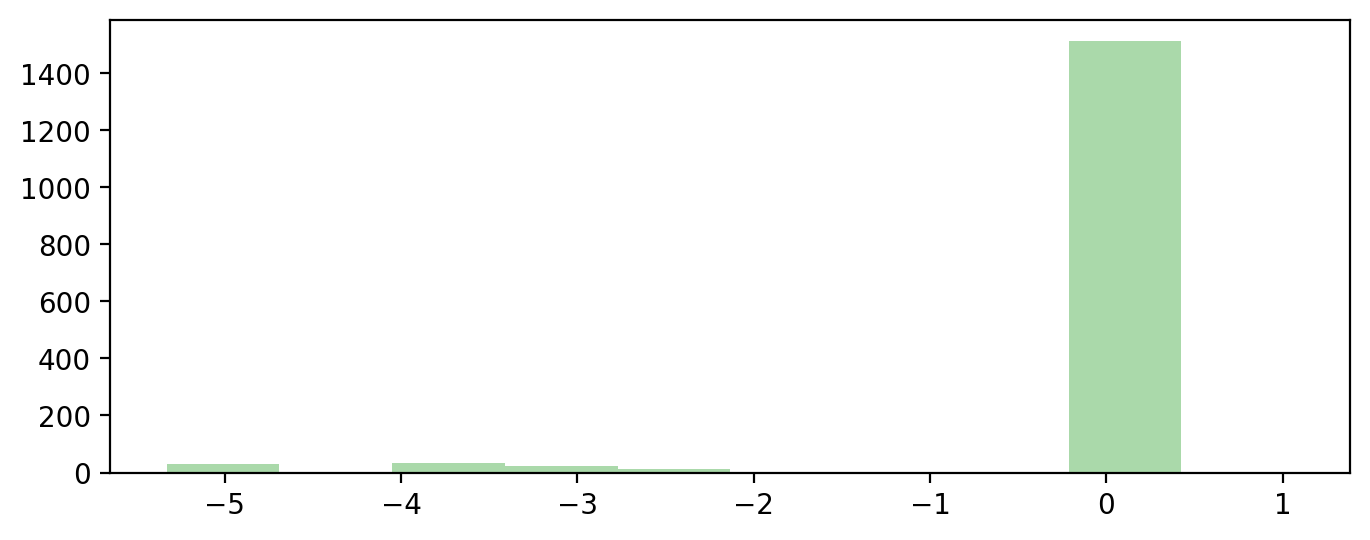

In [106]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
ax.hist(scaled_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')

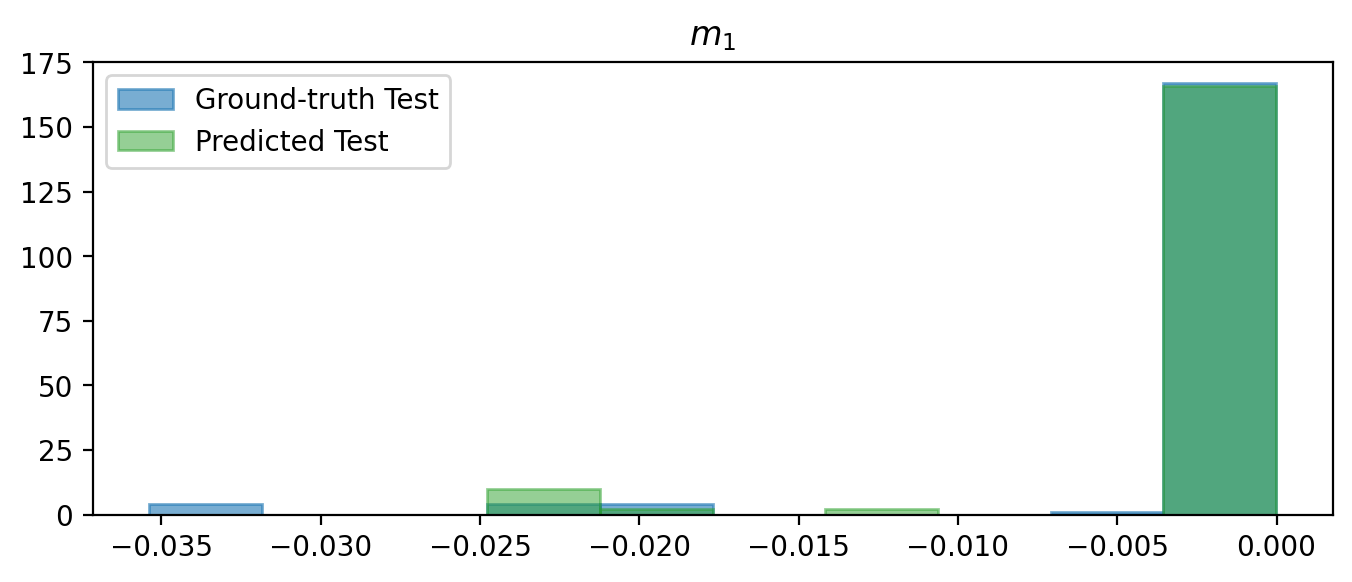

In [107]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,0], bins=10)
ax.hist(slopes_test[:,0], alpha=0.6, label='Ground-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,0],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax[0].set_title('Predicted Test value m1')
# ax.hist(balanced_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_1$')
plt.legend()
# plt.savefig(f'img/m1_hist_{cycle_window_size}_window.png', dpi=400, transparent=False)

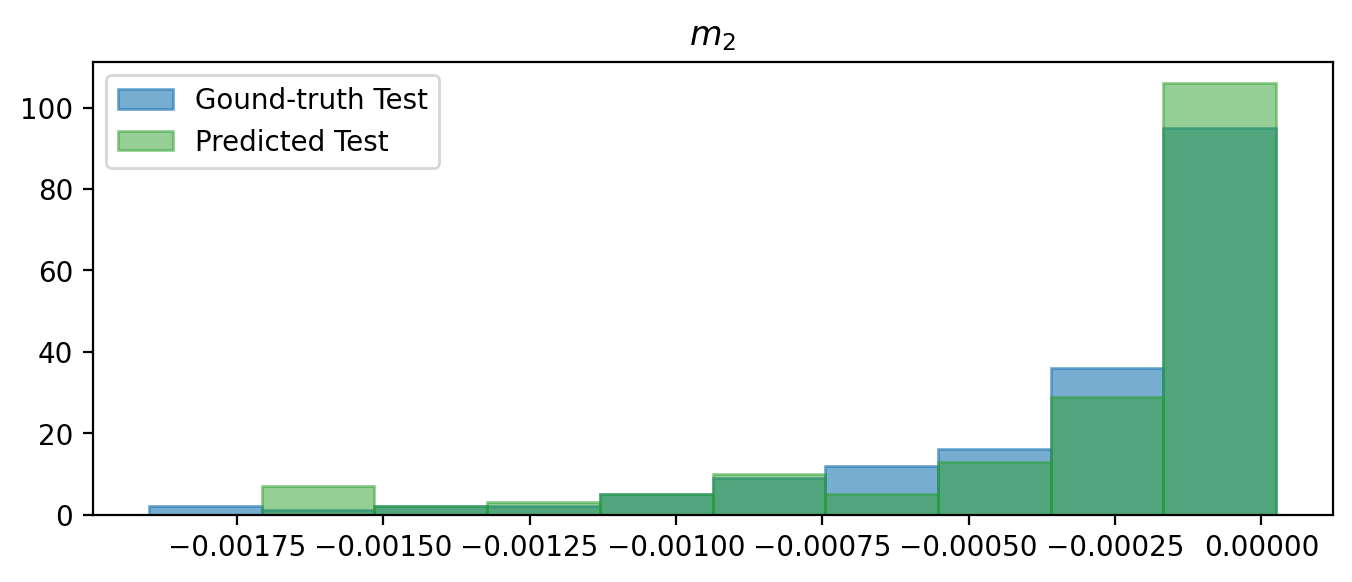

In [108]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,1], bins=10)
ax.hist(slopes_test[:,1], alpha=0.6, label='Gound-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,1],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax.hist(balanced_slopes_train[:,1], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_2$')
plt.legend()
# plt.savefig(f'img/m2_hist_{cycle_window_size}_window.png', dpi=400, transparent=False)

Text(0, 0.5, 'Predicted Value')

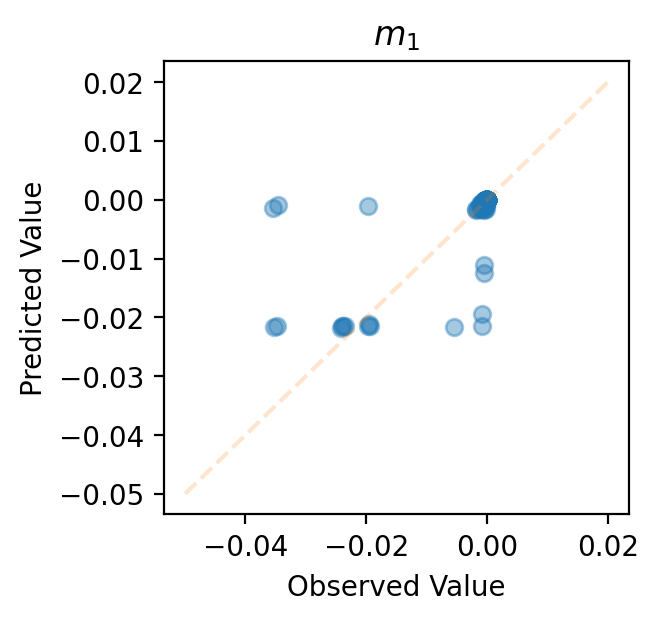

In [109]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,0], Y_hat_test[:,0], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.05,0.02], [-0.05,0.02], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_1$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
# plt.savefig(f'img/m1_parity_{cycle_window_size}_window.png', dpi=400, transparent=False)

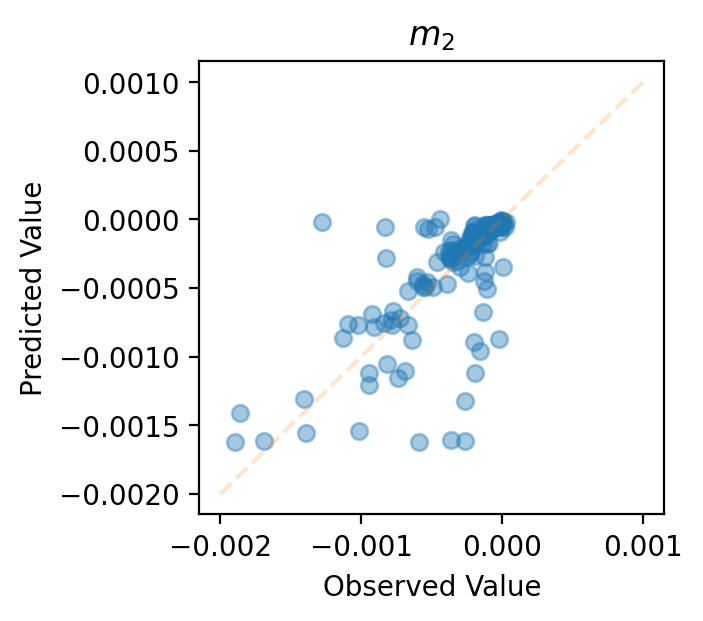

In [110]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,1], Y_hat_test[:,1], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_2$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
ax=plt.gca()
plt.savefig(f'img/m2_parity_{cycle_window_size}_window.png', dpi=400, transparent=False)
# import matplotlib.ticker as mtick
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))

In [111]:
# testing on data
test_cell_number = 5
tested_cell = [test_cells[test_cell_number]]
# X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
# Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# Y_test = [x for xs in test_cells for x in xs[1]]
Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
all_test_slopes = [y[0] for y in Y_tested_cell]
all_test_dc = np.array([y[1] for y in Y_tested_cell])
# Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
_, scaled_X_tested_cell_time_series = scale(X_tested_cell_time_series[...,1:], f_scaler)
Y_hat_tested_cell = model.predict(scaled_X_tested_cell_time_series)
Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)


1/1 [==============================] - 0s 47ms/step


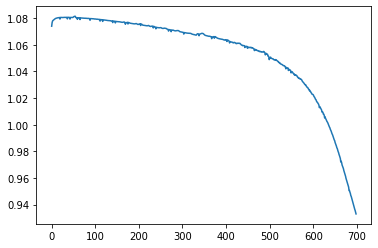

In [112]:
plt.plot(all_test_dc.reshape([-1,2])[1:,1])

predicted slope: -4.541551970760338e-05, True slope: -2.5192000000000548e-05
predicted slope: -3.4444612538209185e-05, True slope: -2.3179999999998203e-05
[[50.0, 1.0806258], [74.5, 1.0795131197671637], [99.0, 1.0786692267599776]]
predicted slope: -5.699185931007378e-05, True slope: -3.643199999999957e-05
predicted slope: -4.538922439678572e-05, True slope: -3.895599999999888e-05
[[100.0, 1.0794187], [124.5, 1.0780223994469031], [149.0, 1.076910363449182]]
predicted slope: -5.490441617439501e-05, True slope: -2.381199999999417e-05
predicted slope: -4.410117617226206e-05, True slope: -6.445600000000162e-05
[[150.0, 1.0775008], [174.5, 1.0761556418037272], [199.0, 1.0750751629875068]]
predicted slope: -5.852644608239643e-05, True slope: -4.963599999999957e-05
predicted slope: -4.71302009827923e-05, True slope: -5.187599999999293e-05
[[200.0, 1.0753665], [224.5, 1.0739326020709812], [249.0, 1.0727779121469028]]
predicted slope: -6.184975791256875e-05, True slope: -0.00012063200000000052
p

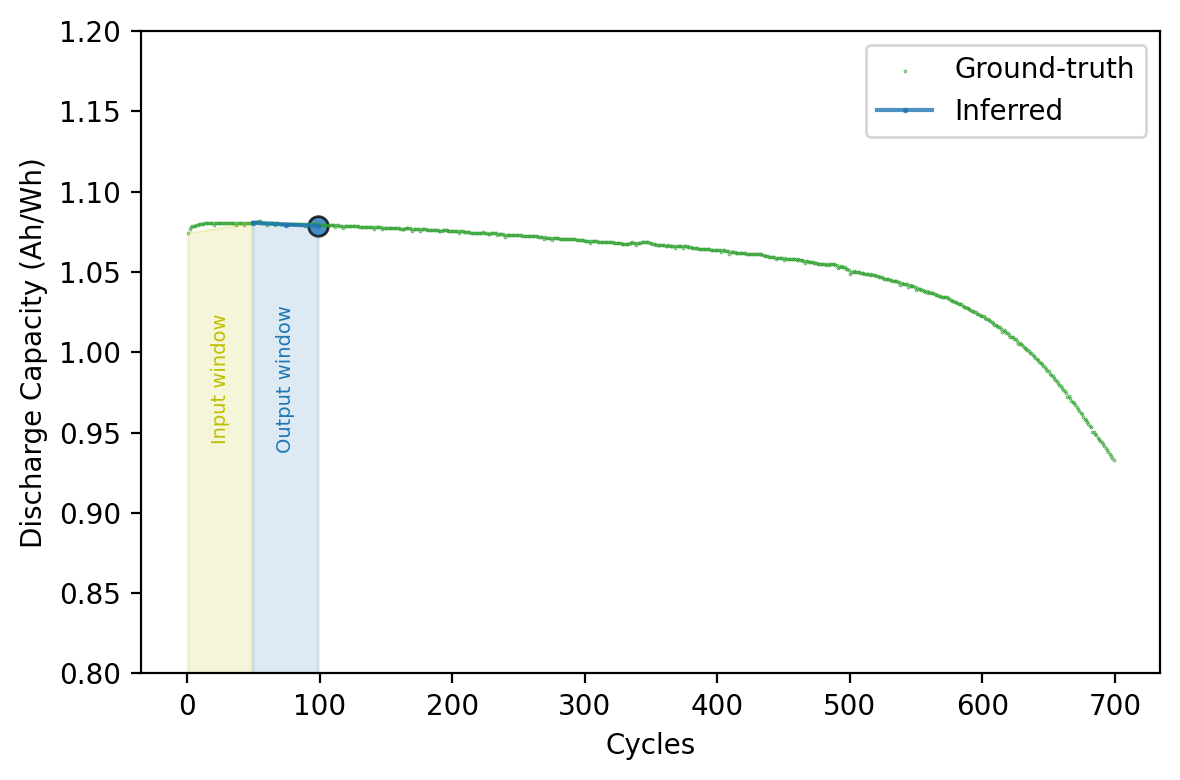

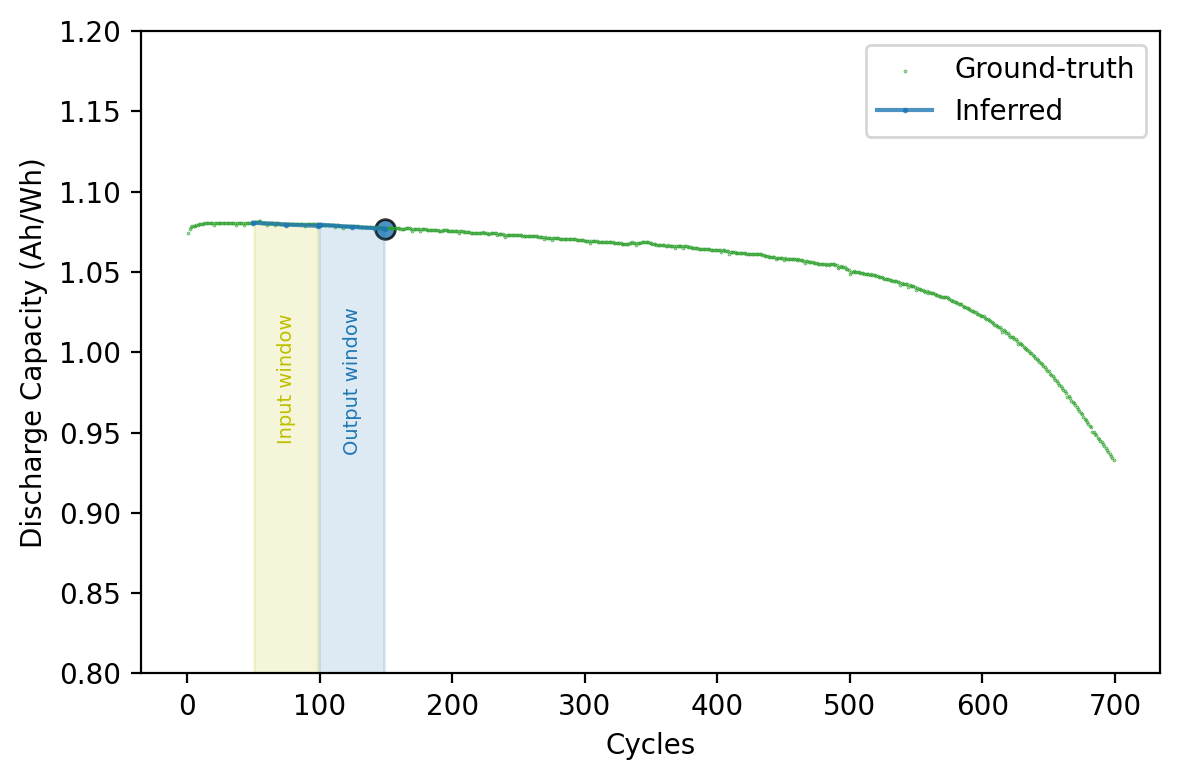

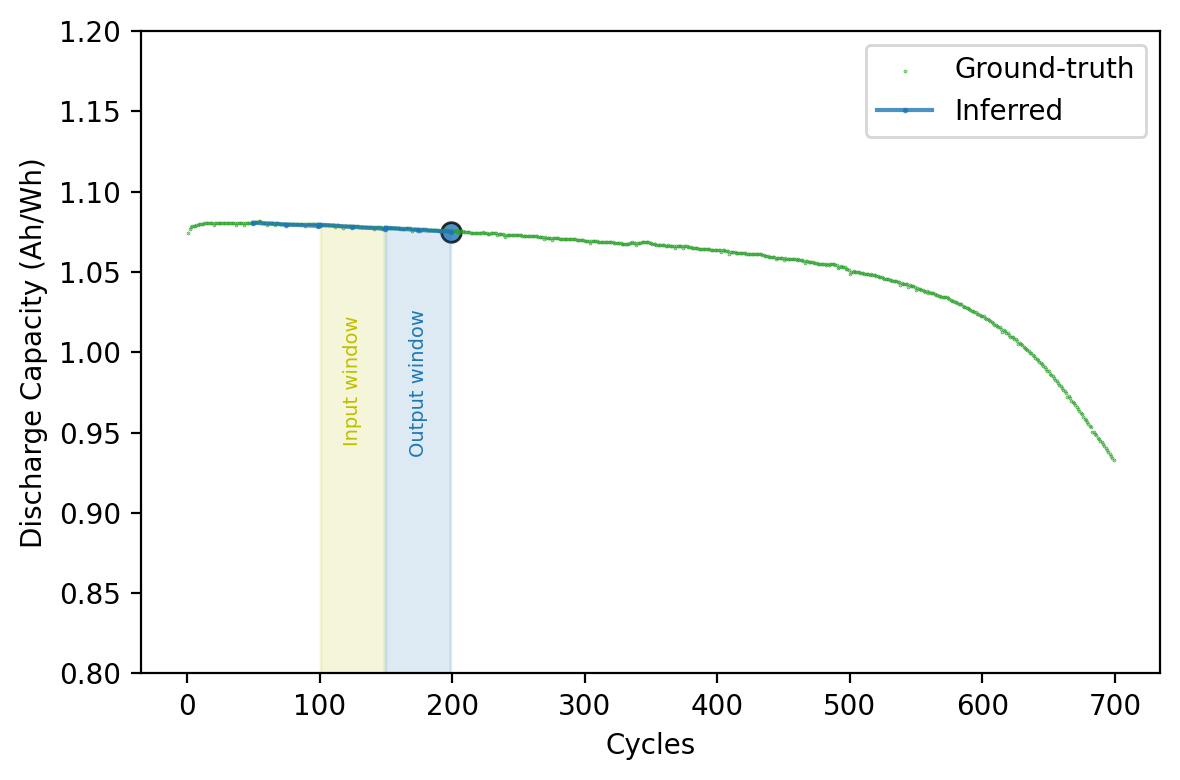

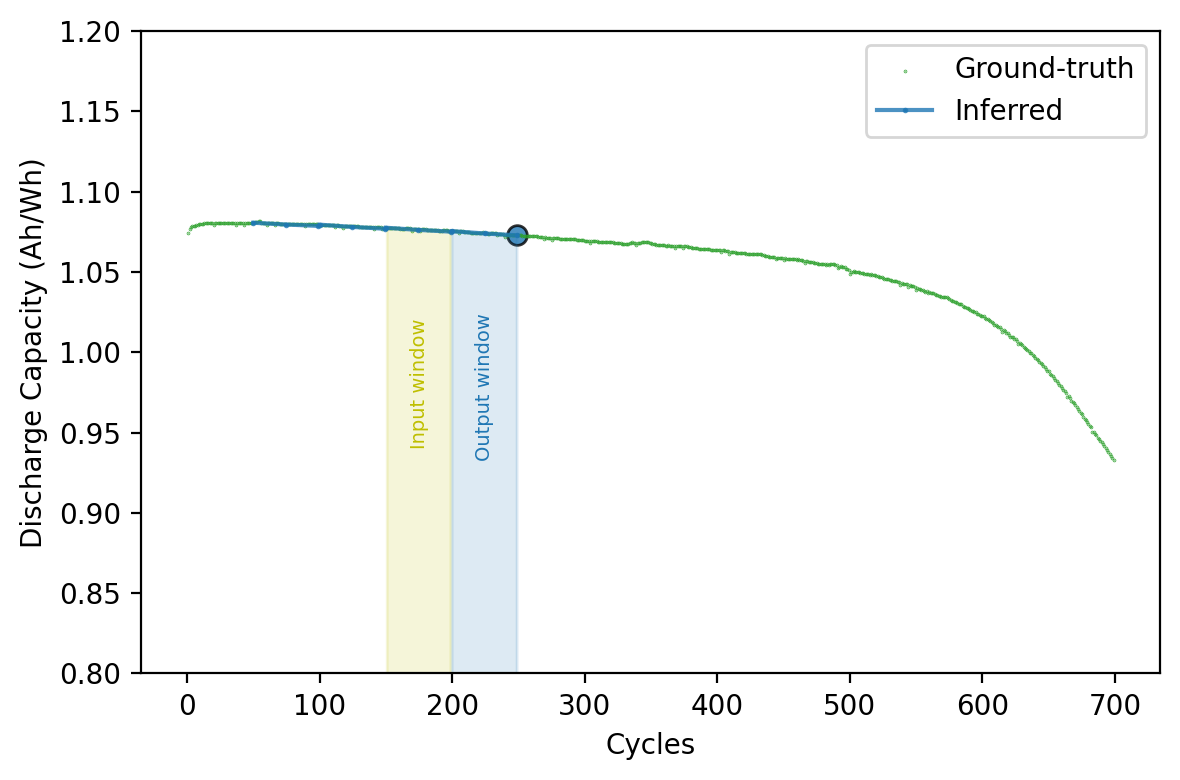

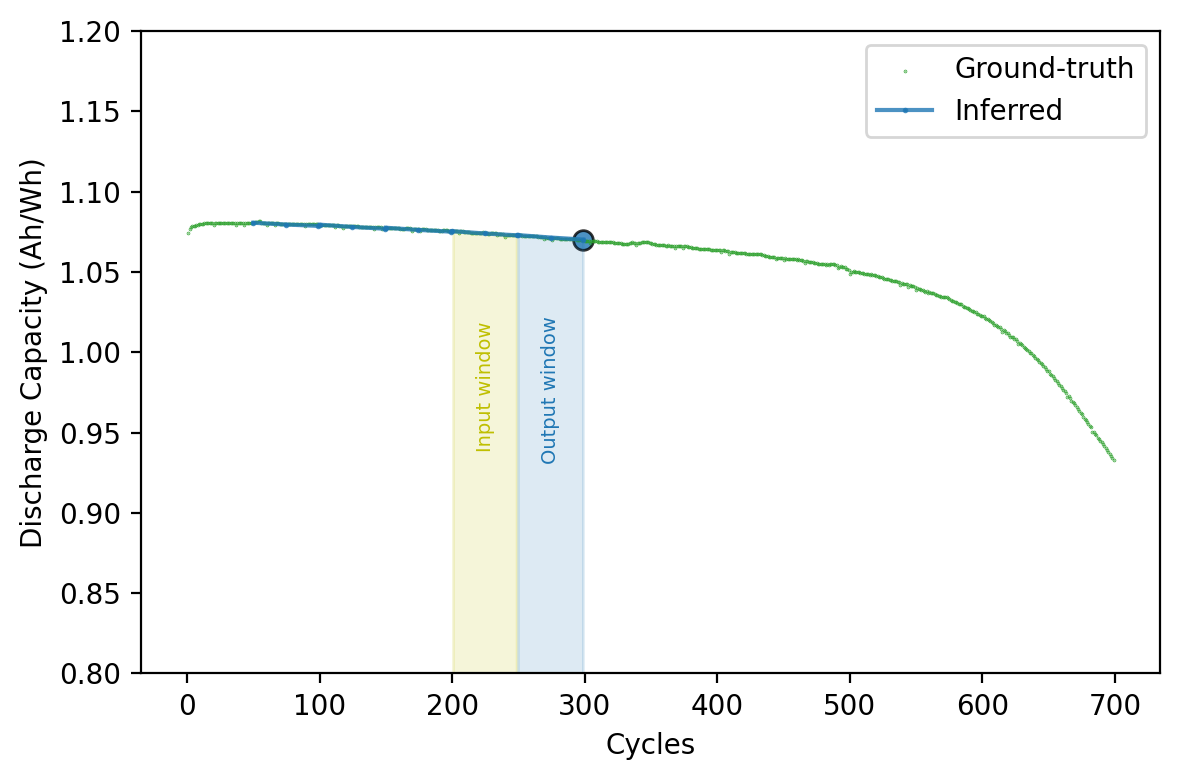

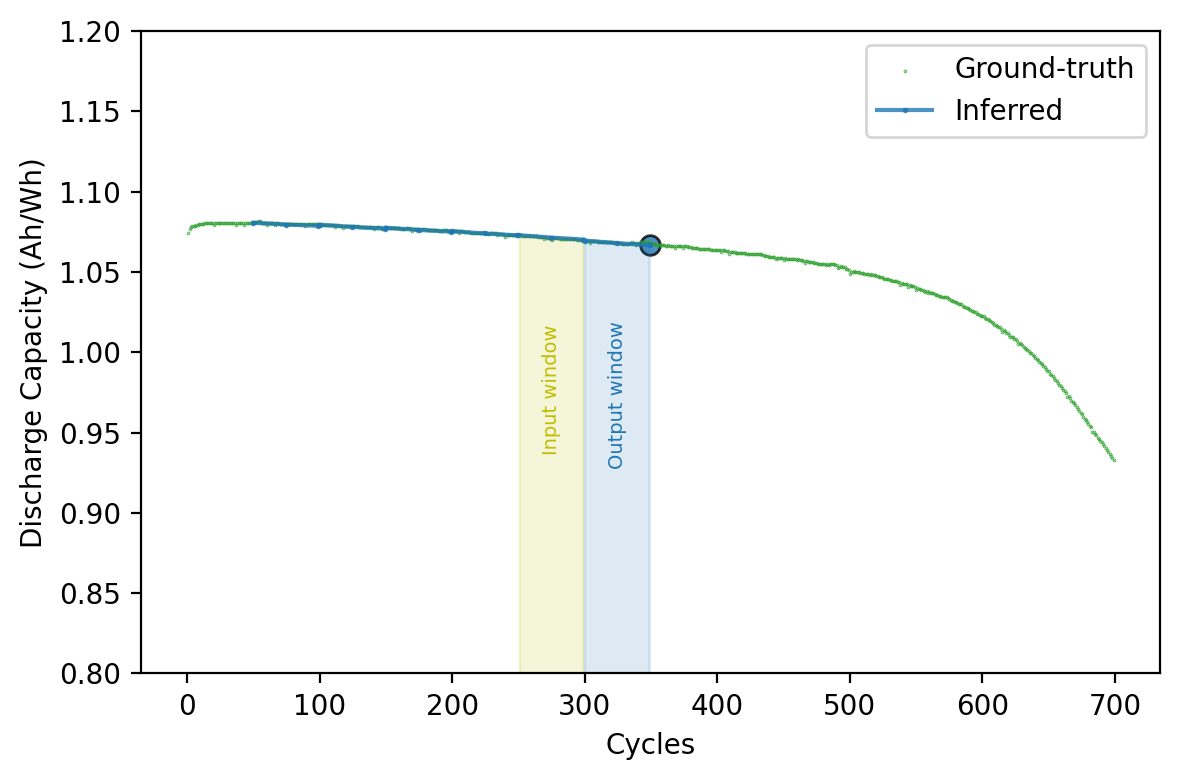

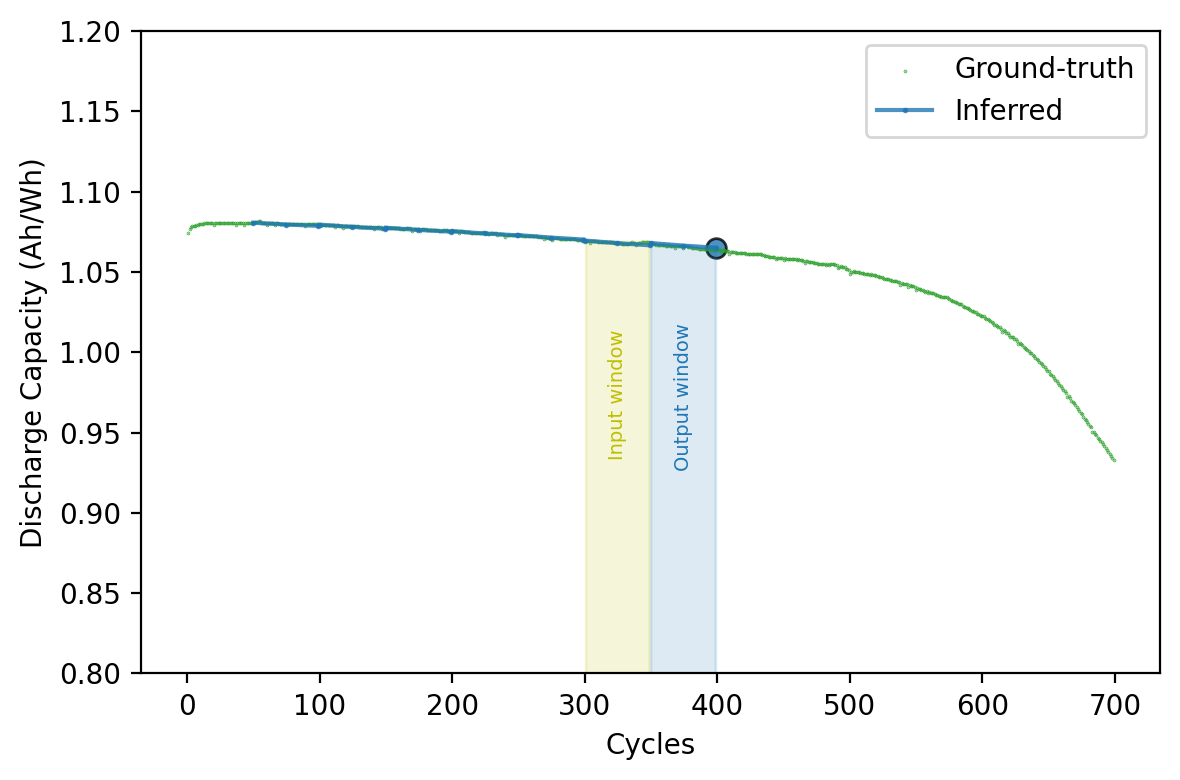

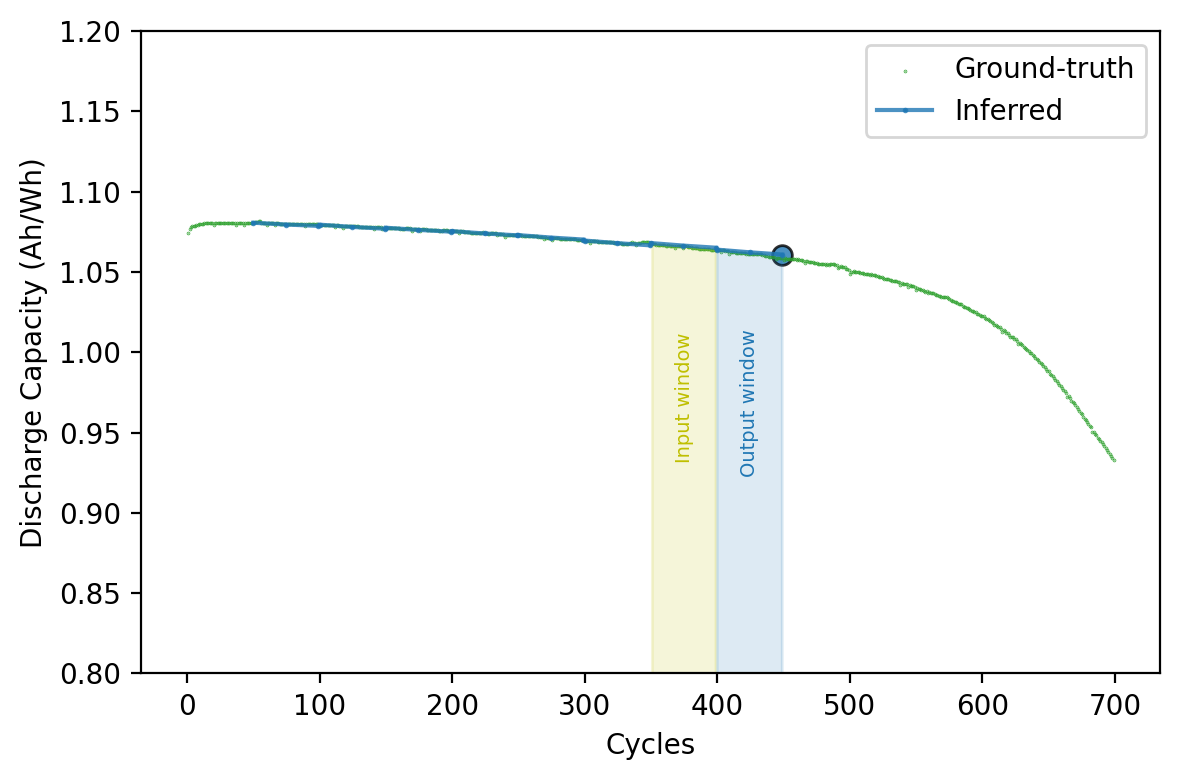

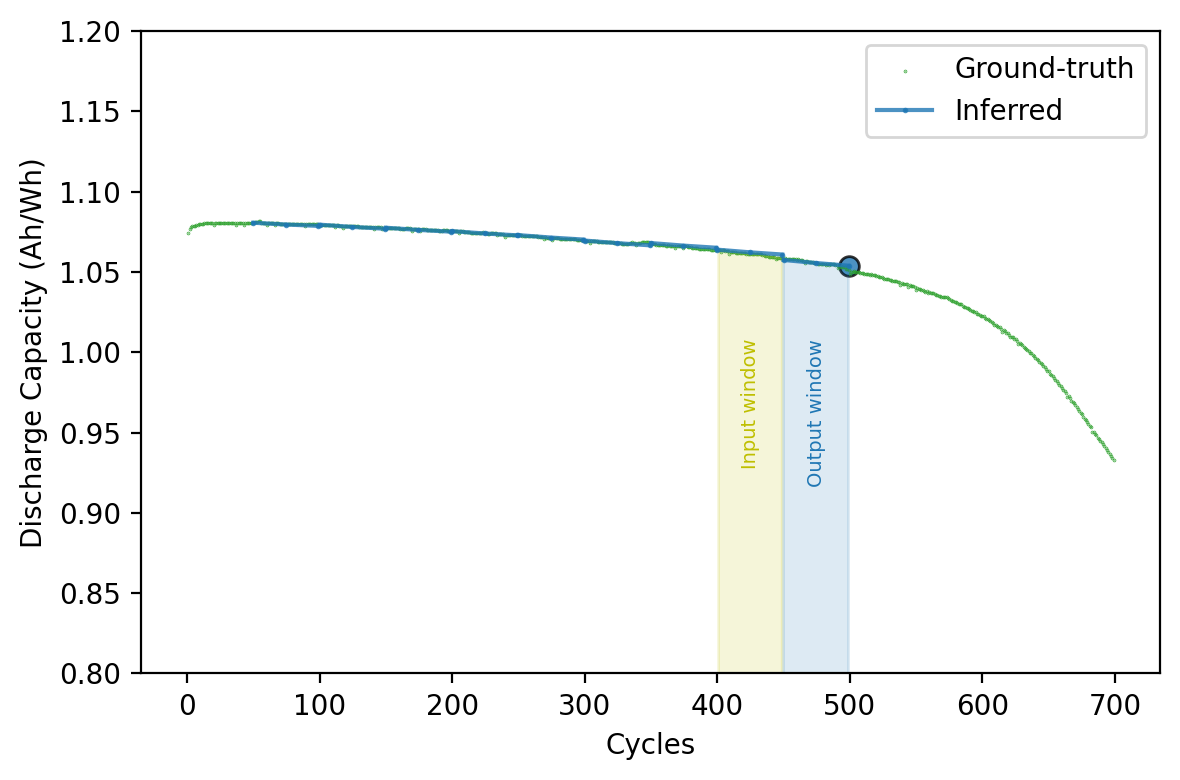

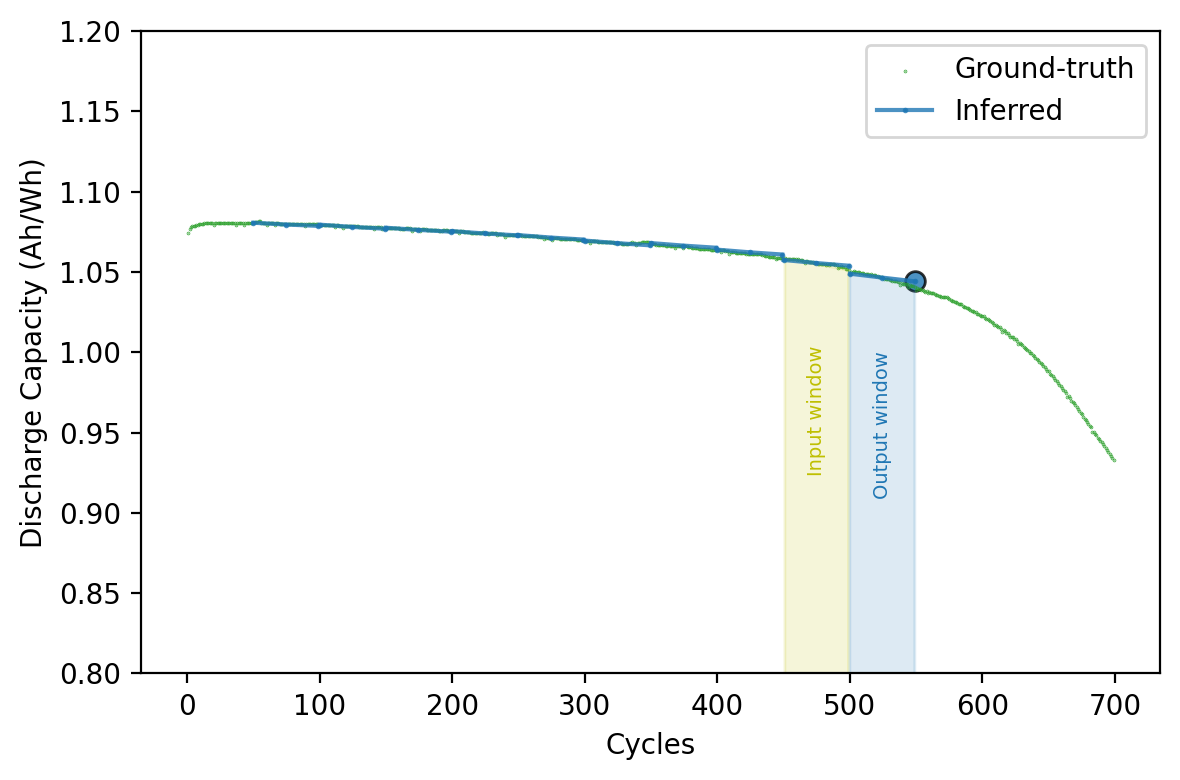

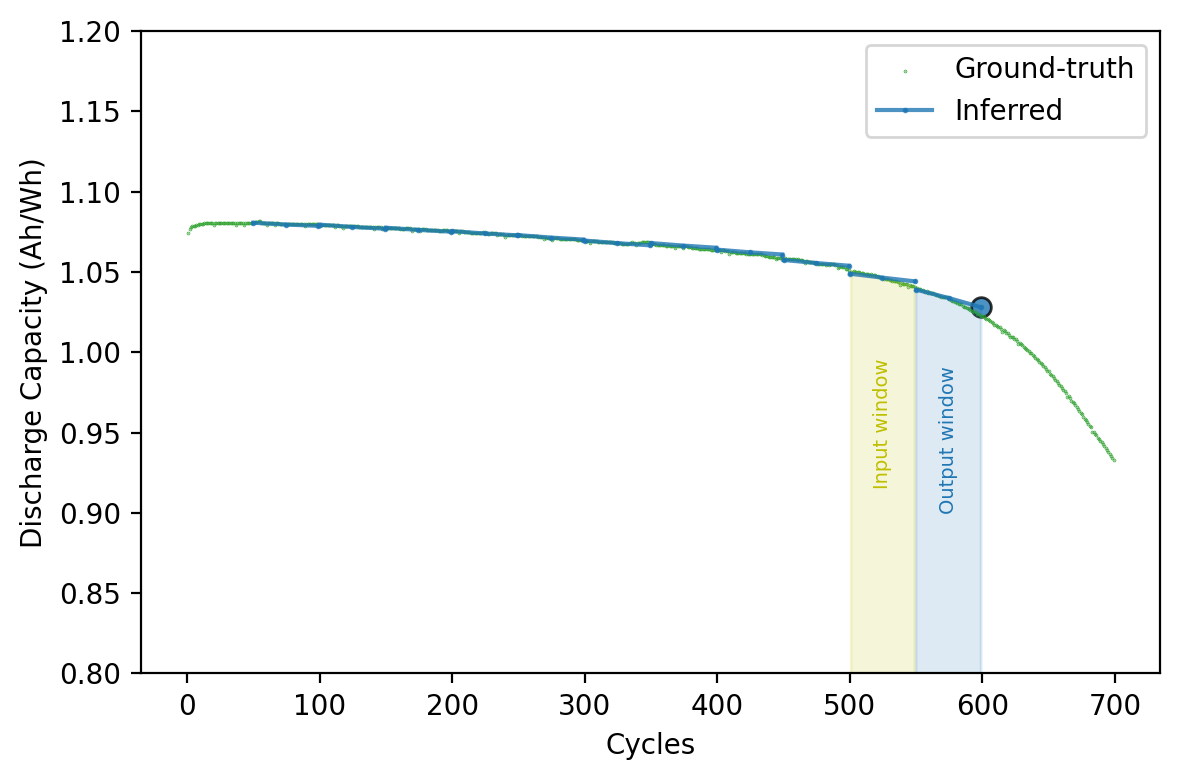

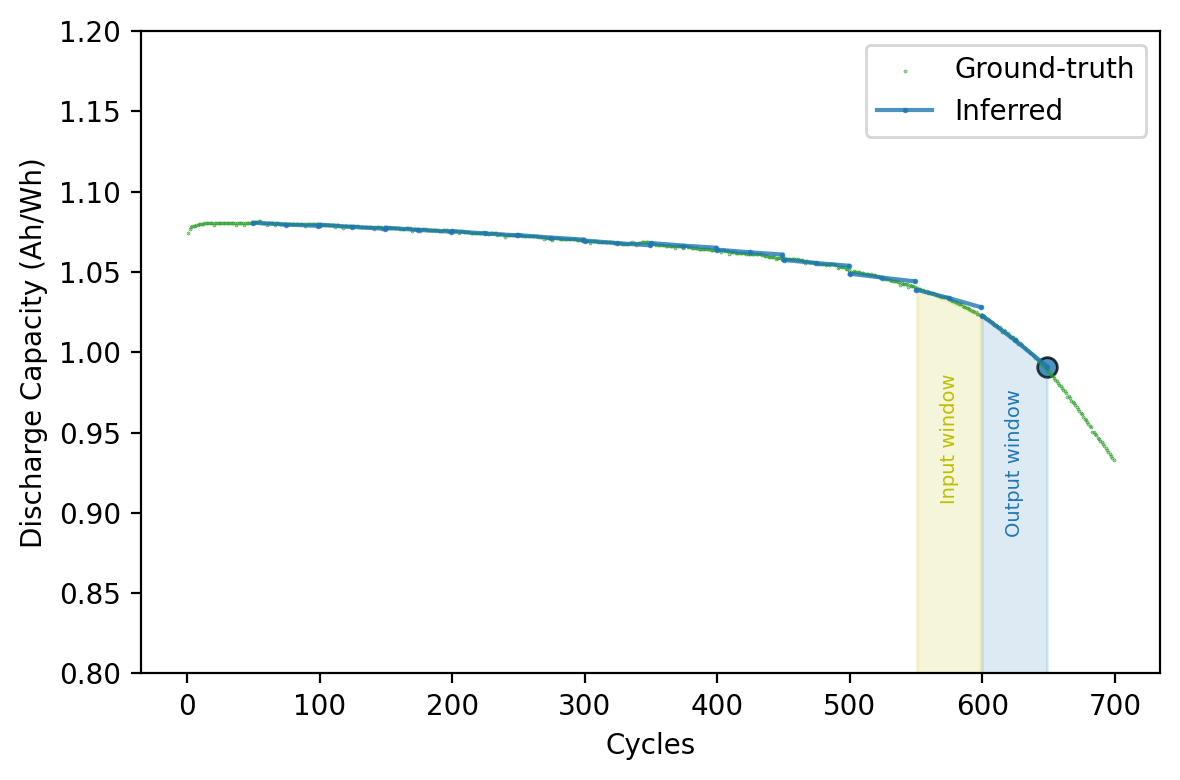

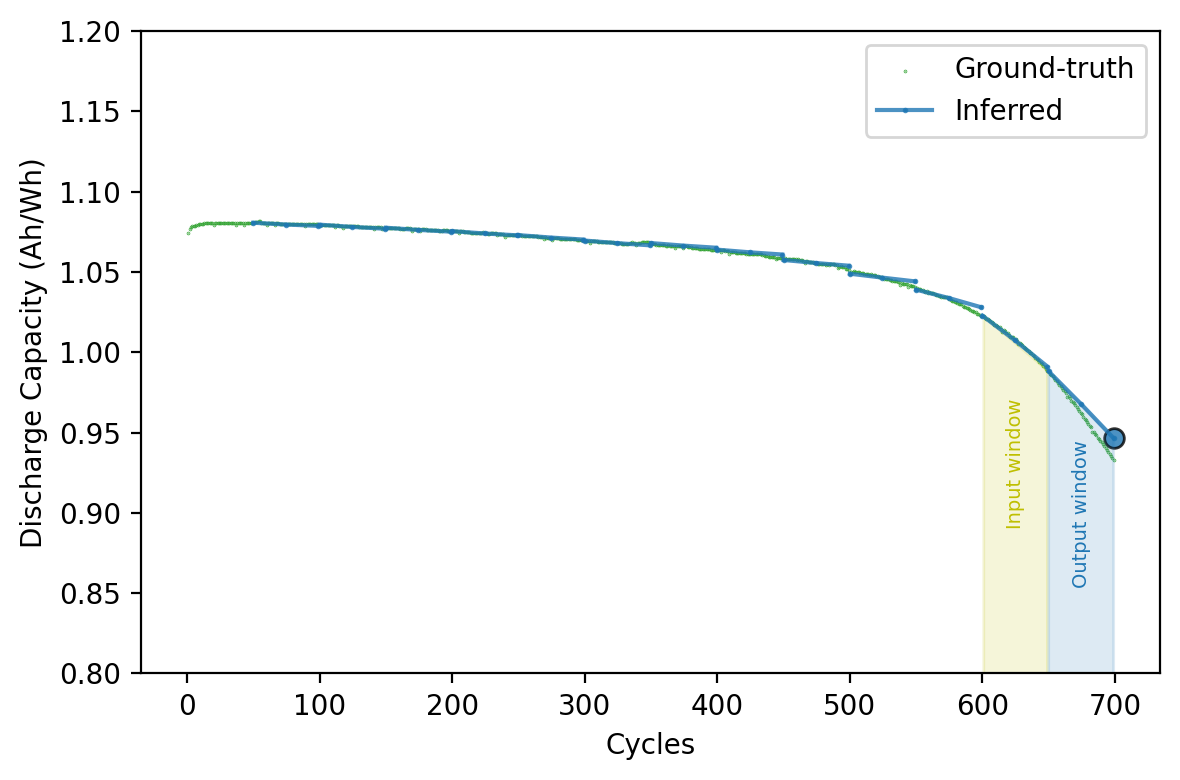

In [113]:
def linear_fit(new_x_point, slope, point_xy):
    return slope*(new_x_point-point_xy[0]) + point_xy[1]

def eval_dc_reconstruction(predicted_dc, ground_truth_dc):
    from scipy.interpolate import interp1d
    f = interp1d(ground_truth_dc[:,0], ground_truth_dc[:,1], kind='cubic')
    interpolated_dc_ground_truth = f(predicted_dc[:,0])
    return np.sqrt(((interpolated_dc_ground_truth - predicted_dc[:,1]) ** 2).mean())


# testing on data
# tested_cell = [test_cells[3]]
# # X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# # Y_train = np.array([x for xs in train_cells for x in xs[1]])
# # Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
# X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# # Y_test = [x for xs in test_cells for x in xs[1]]
# Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
# dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
# X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# # scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# # scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# # std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
# all_test_slopes = [y[0] for y in Y_tested_cell]
# all_test_dc = np.array([y[1] for y in Y_tested_cell])
# # Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
# Y_hat_tested_cell = model.predict(X_tested_cell_time_series[...,1:])

# initial_dc = all_test_dc.reshape([-1, 2])[cycle_indices[0]]
# index_0 = initial_dc[0]
# for i,m in enumerate(all_test_dc.reshape([-1,2])):
#     plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=2, label='Ground-truth' if i == 0 else "")

window_size = cycle_window_size
all_predicted_dc_values = []
for i,m in enumerate(all_test_dc[1:]):
    plt.figure(dpi=200, facecolor='white')
#     print(m[0,0], m[5,0], m[9,0])
    plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")
#     if i == 0:
#         initial_dc = m[0]
    initial_dc = m[0].tolist()
#     print(m)
#     print(m)
#     break
    predicted_dc_values = [initial_dc]
#     print(initial_dc)
#     if i%2 == 0:
    new_cycle_index = m[0,0]
#         print(f'hi {i}')
    for j,slope in enumerate(Y_hat_tested_cell[i]):
        new_cycle_index += (window_size-1)/2#np.floor(window_size/2)
        new_predicted_dc = linear_fit(new_cycle_index, slope, initial_dc) # slopes_tested_cell[i,j]
#         new_predicted_dc = linear_fit(new_cycle_index, -np.exp(-slope), initial_dc)

        print(f'predicted slope: {slope}, True slope: {np.array(slopes_tested_cell)[i,j]}')
        predicted_dc_values.append([new_cycle_index , new_predicted_dc])
        initial_dc = predicted_dc_values[-1]
#         print(initial_dc)
      # 
    print(predicted_dc_values)
#     initial_dc = np.array([new_cycle_index, new_predicted_dc]) 
    
#     print(i)
#     print(predicted_dc_values)
#     initial_dc = predicted_dc_values[-1]
    
#     if i==2 or i==1:
#         print(m)
#         break
#     if i ==2:
#         break
    all_predicted_dc_values.append(predicted_dc_values)
#     print(np.array(scatters).T)
    plt.plot(*np.array(all_predicted_dc_values).T, color='C0', label='Inferred', #if i == 0 else "",
             marker='o', markersize=1, alpha=0.8)
    plt.scatter(*np.array(predicted_dc_values[-1]).T, c='C0', #if i == 0 else "",
         marker='o', s=50, edgecolor='k', linewidth=1, facecolor='C0', zorder=-1, alpha=0.8)
    plt.xlabel('Cycles')
    plt.ylabel('Discharge Capacity (Ah/Wh)')
    plt.ylim([0.8,1.2])
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    plt.legend(np.unique(labl))
    plt.tight_layout()
    show_input_output_windows = True
    if show_input_output_windows:
        input_fill_between = plt.fill_between(*list(zip(all_test_dc[i][1], all_test_dc[i][-1])), alpha=.15,
                                              edgecolor='y', color='y')
        (x0, y0), (x1, y1) = input_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Input window", ha='center', va='center', fontsize=7, color='y', rotation=90)

        prediction_fill_between = plt.fill_between(*list(zip(*predicted_dc_values)), alpha=.15, edgecolor='C0', color='C0')
        (x0, y0), (x1, y1) = prediction_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Output window", ha='center', va='center', fontsize=7, color='C0', rotation=90)

#     break
    save_gif = False
    if save_gif:
        plt.savefig(f'img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}_{i:04d}.png', dpi=400, transparent=False)
#     if i ==20:
        
#         break
#     plt.close()
#     break
#     if i == 2:
        
#         break

# copy last frame
if save_gif:
    for j in range(10):
        os.system(f"cp img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}_{i:04d}.png img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}_{i+j:04d}.png")
    os.system(f"ffmpeg -framerate 1 -i ./img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}_%04d.png -c:v h264 -crf 14 -c:v libx264 -movflags +faststart -vf format=yuv420p -maxrate 50M -tune animation -bufsize 1MB -t 15 -y ./img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}.mp4")
    os.system(f'ffmpeg -i ./img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}.mp4 -framerate 1 -vf "fps=24, scale=2000:-1:flags=lanczos" -loop 0 -y ./img/discharge_curve_{cycle_window_size}_window_test_{test_cell_number}.gif')
# ffmpeg -i discharge_curve_50_window_test_3.mp4 -r 40 -vf "fps=20, scale=2000:-1:flags=lanczos" -f image2pipe -vcodec ppm - | convert -delay 10 -loop 0 - test.gif

In [119]:
dc_rmse = eval_dc_reconstruction(np.array(all_predicted_dc_values).reshape(-1,2), all_test_dc.reshape([-1,2]))
dict_results = {'Input_window_size':cycle_window_size,
                'Prediction window size':cycle_window_size,
                'Test slope MAE':test_result,
                'Test dc RMSE': dc_rmse
               }
import json
with open(f'CACHED_DATA/results/LFP/input_window_{cycle_window_size}_output_window_{cycle_window_size}.json', 'w') as f:
    json.dump(dict_results, f,  indent=4)
dict_results

{'Input_window_size': 50,
 'Prediction window size': 50,
 'Test slope MAE': 0.3009333908557892,
 'Test dc RMSE': 0.002691661779365704}

In [926]:
all_test_dc.reshape([-1,2]).shape

(740, 2)

In [927]:
np.array(all_predicted_dc_values).reshape(-1,2).shape

(219, 2)

In [928]:
all_test_dc.reshape([-1,2])

array([[  0.   ,   1.681],
       [  1.   ,   1.074],
       [  2.   ,   1.077],
       ...,
       [737.   ,   0.888],
       [738.   ,   0.887],
       [739.   ,   0.885]])

In [929]:
np.array(all_predicted_dc_values).reshape(-1,2)

array([[ 10.   ,   1.08 ],
       [ 14.5  ,   1.08 ],
       [ 19.   ,   1.08 ],
       [ 20.   ,   1.079],
       [ 24.5  ,   1.079],
       [ 29.   ,   1.079],
       [ 30.   ,   1.081],
       [ 34.5  ,   1.08 ],
       [ 39.   ,   1.08 ],
       [ 40.   ,   1.081],
       [ 44.5  ,   1.08 ],
       [ 49.   ,   1.08 ],
       [ 50.   ,   1.081],
       [ 54.5  ,   1.08 ],
       [ 59.   ,   1.08 ],
       [ 60.   ,   1.079],
       [ 64.5  ,   1.079],
       [ 69.   ,   1.079],
       [ 70.   ,   1.08 ],
       [ 74.5  ,   1.08 ],
       [ 79.   ,   1.08 ],
       [ 80.   ,   1.08 ],
       [ 84.5  ,   1.08 ],
       [ 89.   ,   1.079],
       [ 90.   ,   1.08 ],
       [ 94.5  ,   1.079],
       [ 99.   ,   1.079],
       [100.   ,   1.079],
       [104.5  ,   1.079],
       [109.   ,   1.079],
       [110.   ,   1.079],
       [114.5  ,   1.079],
       [119.   ,   1.079],
       [120.   ,   1.079],
       [124.5  ,   1.078],
       [129.   ,   1.078],
       [130.   ,   1.078],
 

In [934]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

from scipy.interpolate import interp1d
ground_truth_dc = all_test_dc.reshape([-1,2])
f = interp1d(ground_truth_dc[:,0], ground_truth_dc[:,1], kind='cubic')
test = f(np.array(all_predicted_dc_values).reshape(-1,2)[:,0])


0.0008007483623171746

In [931]:
np.array(all_predicted_dc_values).reshape(-1,2)[:,1] - test

array([-2.220e-16, -4.606e-04, -5.877e-04,  0.000e+00, -1.439e-03,
       -1.672e-03,  0.000e+00, -2.863e-04, -5.288e-04,  0.000e+00,
       -4.122e-04, -3.637e-04, -2.220e-16, -1.222e-03, -2.254e-04,
        0.000e+00, -1.529e-03, -1.457e-03, -2.220e-16, -1.833e-04,
       -2.975e-04,  0.000e+00, -1.969e-04,  9.988e-04,  0.000e+00,
       -2.203e-04, -1.547e-04,  0.000e+00, -1.410e-04, -1.530e-04,
       -2.220e-16, -6.614e-05, -1.456e-04,  0.000e+00, -1.251e-04,
       -8.554e-05, -2.220e-16, -1.291e-04, -1.466e-04, -2.220e-16,
       -1.037e-04, -9.570e-05,  0.000e+00, -1.748e-04, -1.288e-04,
        0.000e+00, -1.966e-04, -2.534e-04, -2.220e-16, -1.857e-03,
       -1.654e-03, -2.220e-16,  7.232e-05,  1.396e-04, -2.220e-16,
       -5.342e-04, -2.998e-05, -2.220e-16,  3.372e-05, -1.504e-04,
       -2.220e-16, -2.670e-05, -4.642e-05,  0.000e+00, -3.126e-04,
       -2.097e-04,  0.000e+00,  4.583e-04,  1.100e-04,  0.000e+00,
       -1.275e-03, -1.408e-03, -2.220e-16,  1.410e-04, -2.640e

In [484]:
list(predicted_dc_values)

[array([50.   ,  1.064]), array([75.   ,  1.064]), array([100.   ,   1.063])]

In [475]:
predicted_dc_values

[array([50.   ,  1.064]), array([75.   ,  1.064]), array([100.   ,   1.063])]

In [456]:
list(zip(all_test_dc[i][0], all_test_dc[i][-1]))

[(0.0, 49.0), (1.5531458, 1.0641226)]

In [462]:
list(zip(all_test_dc[1:]))

[(array([[50.   ,  1.064],
         [51.   ,  1.064],
         [52.   ,  1.064],
         [53.   ,  1.064],
         [54.   ,  1.064],
         [55.   ,  1.064],
         [56.   ,  1.064],
         [57.   ,  1.064],
         [58.   ,  1.064],
         [59.   ,  1.064],
         [60.   ,  1.064],
         [61.   ,  1.064],
         [62.   ,  1.064],
         [63.   ,  1.064],
         [64.   ,  1.064],
         [65.   ,  1.064],
         [66.   ,  1.064],
         [67.   ,  1.064],
         [68.   ,  1.064],
         [69.   ,  1.064],
         [70.   ,  1.064],
         [71.   ,  1.064],
         [72.   ,  1.064],
         [73.   ,  1.064],
         [74.   ,  1.064],
         [75.   ,  1.064],
         [76.   ,  1.064],
         [77.   ,  1.064],
         [78.   ,  1.063],
         [79.   ,  1.063],
         [80.   ,  1.063],
         [81.   ,  1.063],
         [82.   ,  1.063],
         [83.   ,  1.063],
         [84.   ,  1.063],
         [85.   ,  1.063],
         [86.   ,  1.063],
 

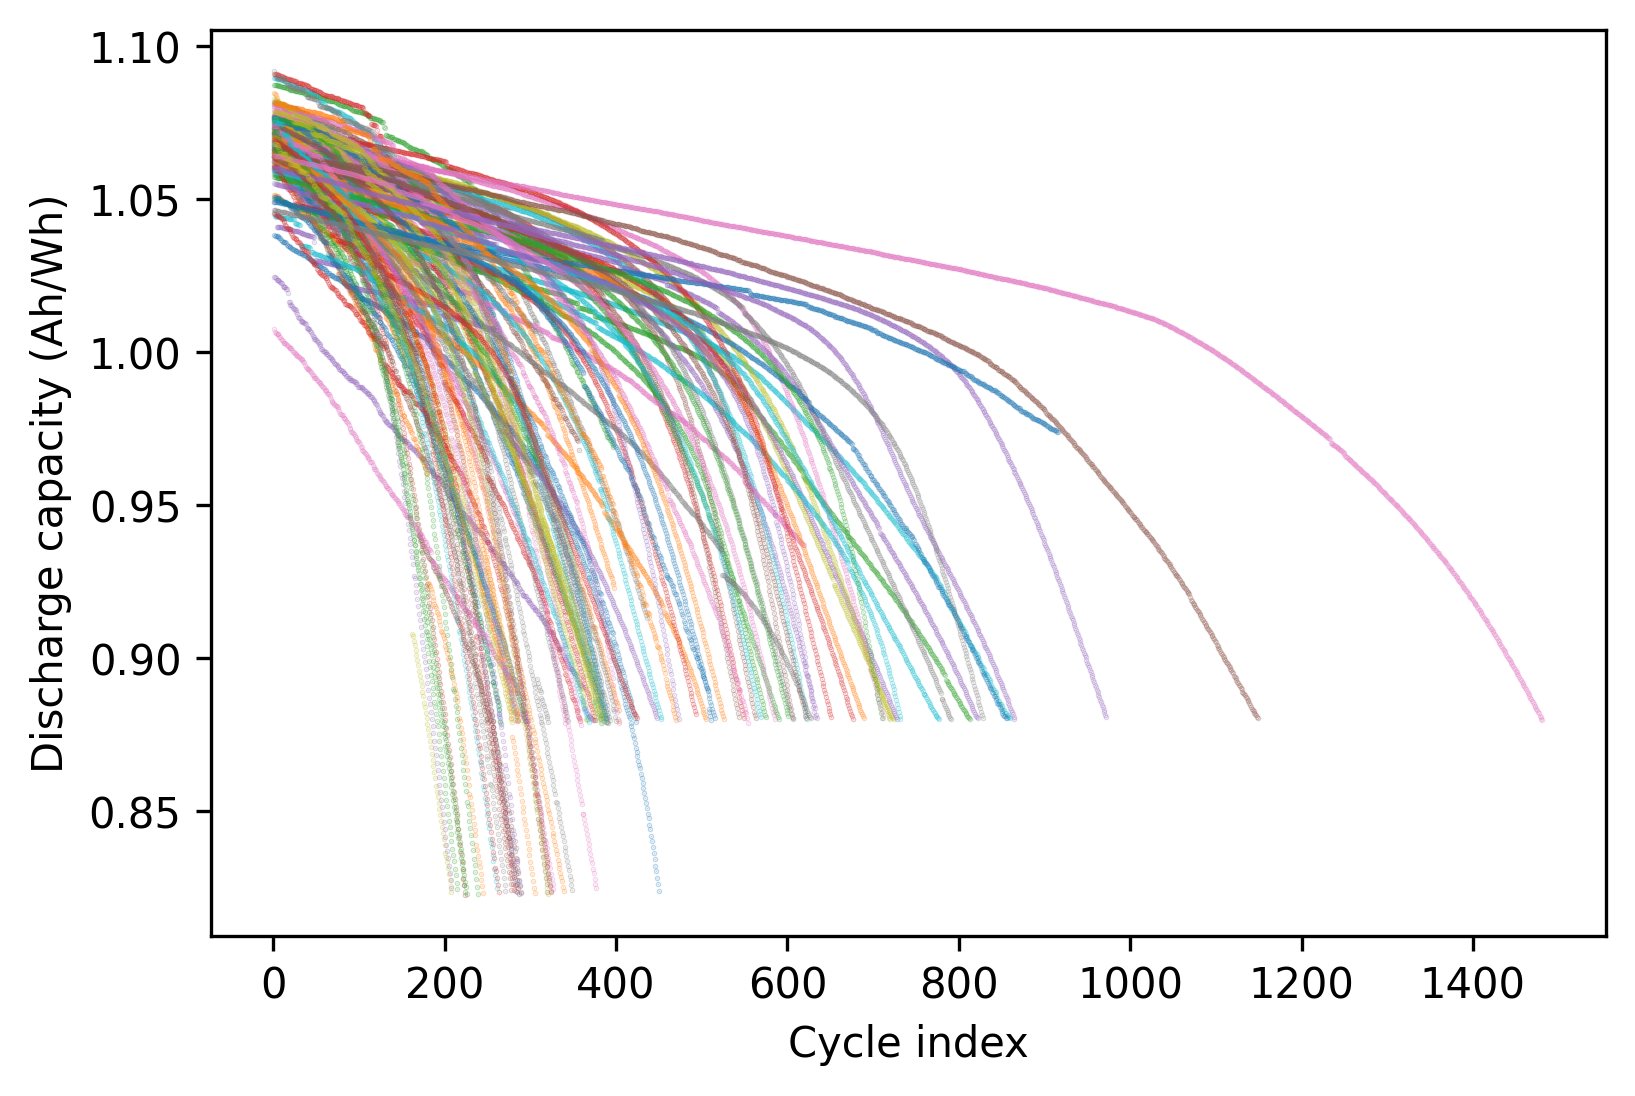

In [33]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycle index')
plt.ylabel('Discharge capacity (Ah/Wh)')
# plt.savefig(f'LFP_dataset.png', dpi=400, transparent=False)